In [561]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from collections import Counter

from mlxtend.frequent_patterns import apriori, association_rules,fpgrowth
import datetime as dt
from datetime import datetime
from collections import defaultdict
from itertools import combinations

### Preprocessing

In [562]:
df = pd.read_csv('Ecom_CRM_analysis.csv',encoding='latin-1')

In [563]:
df.shape

(541909, 8)

 - Dataset has 5,41,909 observations and 8 featrues

In [564]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [565]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


- InvoiceNo (object): Likely unique identifiers for each transaction.
- StockCode (object): Product identifiers.
- Description (object): Product descriptions.
- Quantity (int64): Number of items in each transaction.
- InvoiceDate (object): Date of the transaction (we'll need to convert this to datetime).
- UnitPrice (float64): Price per unit of the product.
- CustomerID (float64): Unique identifier for customers.
- Country (object): Country where the transaction occurred.
- Missing Values:
  - Description has 1,454 null values (541,909 - 540,455).
  - CustomerID has 135,080 null values (541,909 - 406,829).
- All other columns have no null values.

In [566]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


- Quantity:
    Mean: 9.55, Median (50%): 3.00
    The mean is significantly higher than the median, indicating a right-skewed distribution.
    Minimum: -80995, Maximum: 80995
    The presence of negative quantities suggests returns or order cancellations.
    The extremely large range (-80995 to 80995) might indicate outliers or data entry errors.

- UnitPrice:
    Mean: 4.61, Median (50%): 2.08
    Again, the mean is higher than the median, suggesting a right-skewed distribution.
    Minimum: -11062.06, Maximum: 38970.00
    Negative prices are unusual and might represent refunds or data errors.
    The large range in prices suggests a diverse product catalog.

- CustomerID:
    Count: 406,829 (out of 541,909 total rows)
    This confirms our earlier observation about missing CustomerIDs.
    Range: 12346 to 18287
    The CustomerIDs seem to be within a consistent range, which is good for analysis.

In [567]:
df.describe(include='object')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


InvoiceNo:
    Count: 541,909 (matches total rows)
    Unique: 25,900
    This suggests an average of about 21 items per invoice

StockCode:
    Count: 541,909 (matches total rows)
    Unique: 4,070
    This indicates a diverse product catalog

Description:
    Count: 540,455 (1,454 missing values)
    Unique: 4,223
    Slightly more unique descriptions than stock codes, possibly due to variations or data inconsistencies

InvoiceDate:
    Count: 541,909 (matches total rows)
    Unique: 23,260
    This suggests data covers multiple days, possibly a year or more

Country:
    Count: 541,909 (matches total rows)
    Unique: 38
    Indicates a multinational customer base

Most frequent values:
    InvoiceNo: 573585 (appears 1,114 times)
    StockCode: 85123A
    Description: "WHITE HANGING HEART T-LIGHT HOLDER"
    InvoiceDate: "10/31/2011 14:41"
    Country: United Kingdom (appears 495,478 times, about 91.4% of all transactions)

### Duplicate Entries removal

In [568]:
df.drop_duplicates(inplace=True)

In [569]:
df.shape

(536641, 8)

- Original dataset size: 541,909 rows
- Dataset size after removing duplicates: 536,641 rows
- Number of duplicates removed: 5,268 (about 0.97% of the original dataset)

In [570]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

- Missing Values:
    Description: 1,454 null values
    CustomerID: 135,037 null values
    All other columns have no null values

- Implications:
    - a) Description (1,454 nulls):
    This is a relatively small number (about 0.27% of the dataset).
    - b) CustomerID (135,037 nulls):
    This is a significant number, representing about 25.16% of the dataset.
    These rows likely represent guest purchases or transactions where customer information wasn't captured.

In [571]:
df['CustomerID'].fillna('Guest', inplace=True)
df['Description'].fillna('Unknown', inplace=True)

In [572]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

- Null values imputedand now there are no missing values in dataset.

In [573]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

- As InvoiceDate was intitally in object datatype and for our processing the same is converted into the correct datetime format

In [574]:
#When we check the InvoiceNo column in the dataset, some rows are prefixed with 'C'. 
df['InvoiceNo'].str.contains('C').value_counts()

False    527390
True       9251
Name: InvoiceNo, dtype: int64

- Invoices containing 'C':
9,251 invoices contained 'C',likely indicating cancelled orders

In [575]:
(df['Description'] == 'POSTAGE').value_counts()

False    535389
True       1252
Name: Description, dtype: int64

- Postage entries:
1,252 entries were marked as 'POSTAGE'

In [576]:
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df = df[~df['InvoiceNo'].str.contains('C')]
df = df[df['Description'] != "POSTAGE"]
df.shape

(526264, 8)

- These cancled order and Postage is removed from df.

In [577]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [578]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 526264 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    526264 non-null  object        
 1   StockCode    526264 non-null  object        
 2   Description  526264 non-null  object        
 3   Quantity     526264 non-null  int64         
 4   InvoiceDate  526264 non-null  datetime64[ns]
 5   UnitPrice    526264 non-null  float64       
 6   CustomerID   526264 non-null  object        
 7   Country      526264 non-null  object        
 8   TotalAmount  526264 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 40.2+ MB


### Outlier Treatment

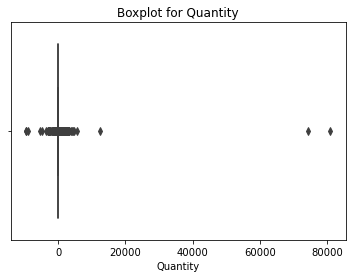

In [579]:
# Boxplot for Quantity
sns.boxplot(df['Quantity'])
plt.title('Boxplot for Quantity')
plt.show()

- Extremely Wide Range: The quantity values range from below 0 to around 80,000, indicating a very wide spread in order quantities.
- Highly Skewed Distribution: The box (representing the interquartile range) is compressed near the bottom of the plot, with the median line barely visible. This suggests the distribution is extremely right-skewed.
- Numerous Outliers: There are many points plotted individually beyond the whiskers, particularly on the high end. These represent outlier values, indicating some orders have exceptionally high quantities.
- Majority of Orders are Small: The compressed nature of the box near the bottom suggests that the vast majority of orders have relatively small quantities, probably in the range of 1-10 items.
- Possible Negative Values: The presence of points below 0 on the y-axis suggests there might be negative quantity values, which could represent returns or order cancellations.

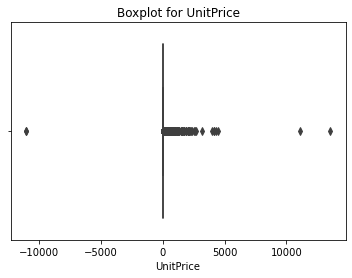

In [580]:
# Boxplot for UnitPrice
sns.boxplot(df['UnitPrice'])
plt.title('Boxplot for UnitPrice')
plt.show()

- Wide Range: The unit prices range from approximately -12,000 to over 10,000, indicating a very wide spread in pricing.
- Highly Skewed Distribution: The box (representing the interquartile range) is extremely compressed, appearing almost as a single line near zero. This suggests the distribution is heavily right-skewed.
- Numerous Outliers: There are many points plotted individually beyond the whiskers on both sides, representing outlier values. This indicates some products have exceptionally high or low (including negative) unit prices.
- Majority of Prices are Low: The compressed nature of the box near zero suggests that the vast majority of products have relatively low unit prices.
- Negative Prices: The presence of points on the negative side of the x-axis suggests there are negative unit prices. This could represent discounts, refunds, or data entry errors.

In [581]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df, 'Quantity')
df = remove_outliers(df, 'UnitPrice')

print("Data shape after outlier removal:", df.shape)

Data shape after outlier removal: (461609, 9)


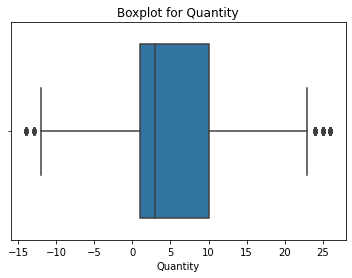

In [582]:
# Boxplot for Quantity - After Outlier Treatment
sns.boxplot(df['Quantity'])
plt.title('Boxplot for Quantity')
plt.show()

- Data Range: The quantity values now range from approximately -15 to 25, indicating a much tighter distribution compared to the original dataset.
- Median: The median (represented by the line in the box) appears to be slightly above 0, suggesting that most transactions involve small positive quantities.
- Interquartile Range (IQR): The box, representing the middle 50% of the data, spans from about 0 to 10. This indicates that the majority of orders are for relatively small quantities.
- Skewness: The distribution is slightly right-skewed, as the upper whisker and outliers extend further than the lower ones.
- Outliers: There are still some outliers present, particularly on the upper end (around 25) and a few on the lower end (around -15). These represent unusual but not extreme quantities.
- Negative Values: The presence of negative quantities (down to about -15) likely represents returns or order cancellations.

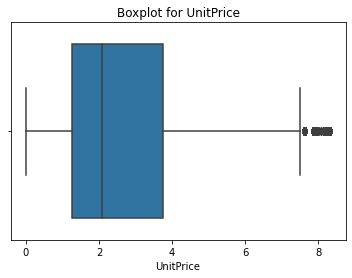

In [583]:
# Boxplot for UnitPrice - After Outlier Treatment
sns.boxplot(df['UnitPrice'])
plt.title('Boxplot for UnitPrice')
plt.show()

- Price Range: The unit prices now range from approximately 0 to 8, which is a significant reduction from the previous range that included extreme negative and positive values.
- Median: The median (vertical line in the box) appears to be around 2-3, indicating that half of the products have unit prices below this value.
- Interquartile Range (IQR): The box, representing the middle 50% of the data, spans from about 1.5 to 4. This suggests that most products are priced within this range.
- Skewness: The distribution is right-skewed, as evidenced by the longer upper whisker and the presence of outliers on the high end.
- Outliers: There are several outliers on the upper end, clustered around 8. These represent products with unusually high prices compared to the bulk of the inventory.
- No Negative Prices: Unlike the previous plot, there are no negative unit prices, indicating that problematic data points (like refunds or data errors) have been removed.

In [584]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### Univariate Analysis

In [585]:
print("\nUnivariate Analysis:")
print('---------------------')
df[['Quantity', 'UnitPrice', 'TotalAmount']].describe()


Univariate Analysis:
---------------------


,Quantity,UnitPrice,TotalAmount
count,461609.000000,461609.000000,461609.000000
mean,6.167988,2.591252,11.695088
std,6.405611,1.931587,13.170679
min,-14.000000,0.000000,0.000000
25%,1.000000,1.250000,3.300000
50%,3.000000,2.080000,8.150000
75%,10.000000,3.750000,15.900000
max,26.000000,8.330000,215.540000


- Sample Size:
 - There are 461,609 records in the cleaned dataset, providing a substantial sample for analysis.
 
- Quantity:
  - Mean: 6.17, suggesting that on average, customers order about 6 items per transaction.
  - Median (50%): 3, indicating that half of the orders are for 3 or fewer items.
  - The distribution is right-skewed (mean > median).
  - Range: -14 to 26, confirming the presence of returns (negative values) and larger orders.
  - 75% of orders are for 10 or fewer items.

- UnitPrice:
    - Mean: £2.59, average price per item.
    - Median: £2.08, suggesting a slight right skew in pricing.
    - Range: £0 to £8.33, indicating a wide variety of price points.
    - 75% of items are priced at £3.75 or less.

- TotalAmount:
    - Mean: £11.70, average transaction value.
    - Median: £8.15, indicating a right-skewed distribution of transaction values.
    - Range: £0 to £215.54, showing significant variation in order totals.
    - 75% of transactions are £15.90 or less.

- Distribution Characteristics:
    - All three variables show right-skewed distributions (mean > median).
    - There's considerable variability in all measures, as indicated by the standard deviations.

- Business Insights:
    - The business deals primarily in lower-priced items, with some higher-priced exceptions.
    - Most transactions are relatively small in both quantity and total amount.
    - There's a long tail of larger orders and higher-priced items.




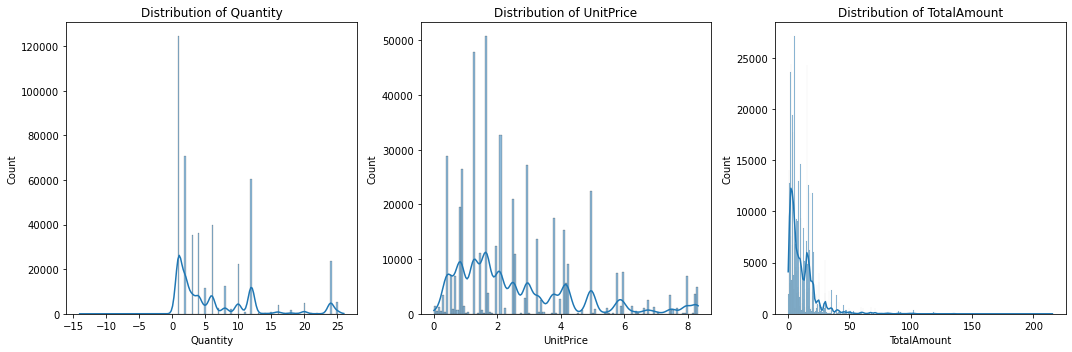

In [586]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Quantity', 'UnitPrice', 'TotalAmount']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

- Quantity:
The average order contains about 6 items, but there's significant variation (std dev: 6.41).
There are negative quantities, which likely represent returns or data errors.
The distribution is right-skewed, with most orders having fewer items and some having many (up to 26).
- UnitPrice:
The average unit price is £2.59, with prices ranging from £0 to £8.33.
There are items with £0 price, which could be free items, promotions, or data errors.
The price distribution is also right-skewed, with most items priced lower and some premium items at higher prices.
- TotalAmount:
The average transaction amount is £11.70, but there's high variability (std dev: £13.17).
Transaction amounts range from £0 to £215.54, indicating a wide spread of order values.
The distribution is heavily right-skewed, with many lower-value transactions and some high-value outliers.

In [587]:
# Investigate negative quantities
neg_qty = df[df['Quantity'] < 0]
print("Negative Quantities:")
print(f"Number of records with negative quantity: {len(neg_qty)}")
print("\nSample of records with negative quantity:")
neg_qty.head()

Negative Quantities:
Number of records with negative quantity: 463

Sample of records with negative quantity:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
2406,536589,21777,Unknown,-10,2010-12-01 16:50:00,0.0,Guest,United Kingdom,-0.0
7190,536998,85067,Unknown,-6,2010-12-03 15:30:00,0.0,Guest,United Kingdom,-0.0
7193,537001,21653,Unknown,-6,2010-12-03 15:33:00,0.0,Guest,United Kingdom,-0.0
7195,537003,85126,Unknown,-2,2010-12-03 15:33:00,0.0,Guest,United Kingdom,-0.0
7203,537011,22139,Unknown,-5,2010-12-03 15:38:00,0.0,Guest,United Kingdom,-0.0


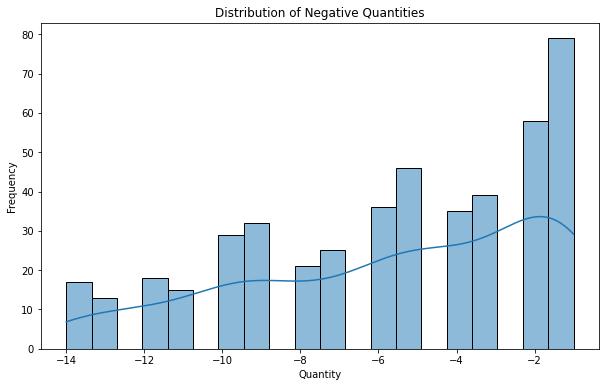

In [588]:
# Visualize negative quantities
plt.figure(figsize=(10, 6))
sns.histplot(neg_qty['Quantity'], bins=20, kde=True)
plt.title('Distribution of Negative Quantities')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

- Return Behavior: The graph represents return transactions or order cancellations, as indicated by the negative quantities.
- Range of Returns: The returns range from -14 to -1 units, with -1 and -2 being the most common return quantities.
- Frequency Pattern: There's a clear trend showing that smaller return quantities are more frequent than larger ones.
- Most Common Returns:
    - Single item returns (-1) are the most frequent, with about 80 occurrences.
    - Two-item returns (-2) are the second most common, with around 60 occurrences.
- Decreasing Frequency: As the absolute value of the negative quantity increases, the frequency generally decreases, with some fluctuations.
- Unusual Large Returns: There are relatively few instances of large quantity returns (e.g., -12 to -14 items), but they do occur.
- Possible Bulk Return Behavior: The slight increases in frequency for certain quantities (like -6 or -12) might indicate common bulk purchase sizes that are sometimes returned.
- Customer Behavior Insight: Customers are more likely to return small quantities, possibly indicating that they're more comfortable with small purchases or tend to regret larger ones.

In [589]:
# Investigate zero-priced items
zero_price = df[df['UnitPrice'] == 0]
print("\nZero-Priced Items:")
print(f"Number of records with zero price: {len(zero_price)}")
print("\nSample of records with zero price:")
zero_price.head()


Zero-Priced Items:
Number of records with zero price: 1393

Sample of records with zero price:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
1970,536545,21134,Unknown,1,2010-12-01 14:32:00,0.0,Guest,United Kingdom,0.0
1971,536546,22145,Unknown,1,2010-12-01 14:33:00,0.0,Guest,United Kingdom,0.0
1972,536547,37509,Unknown,1,2010-12-01 14:33:00,0.0,Guest,United Kingdom,0.0
1987,536549,85226A,Unknown,1,2010-12-01 14:34:00,0.0,Guest,United Kingdom,0.0
1988,536550,85044,Unknown,1,2010-12-01 14:34:00,0.0,Guest,United Kingdom,0.0


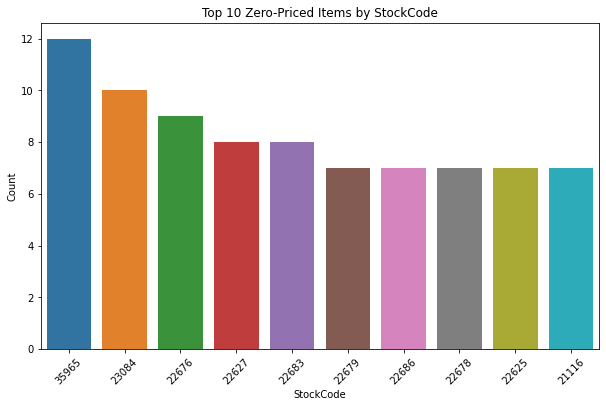

In [590]:
# Visualize zero-priced items
plt.figure(figsize=(10, 6))
sns.countplot(x='StockCode', data=zero_price, order=zero_price['StockCode'].value_counts().index[:10])
plt.title('Top 10 Zero-Priced Items by StockCode')
plt.xlabel('StockCode')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

- Presence of Zero-Priced Items: The company has multiple items in their inventory that are priced at zero. This is an unusual practice in typical retail and requires further investigation.
- Frequency Distribution: The number of zero-priced occurrences varies across different stock codes, ranging from about 7 to 12 instances.
- Most Frequent Zero-Priced Item: StockCode 35905 has the highest count of zero-priced instances, with about 12 occurrences.
- Variation in Frequency: There's a gradual decrease in the frequency of zero-pricing from the most common to the least common item in this top 10 list.
- Potential Patterns: The presence of consecutive stock codes (e.g., 22626, 22627) suggests these might be related items or part of a set.
- Limited Scope: The fact that we're only seeing the top 10 implies there may be more zero-priced items beyond this list, albeit with lower frequencies.
- Inventory Management Implications: The consistent occurrence of zero-priced items across multiple stock codes indicates this is likely a deliberate practice rather than data errors.
- Possible Business Strategies: These zero-priced items could represent:
    - Free gifts with purchase
    - Samples
    - Promotional items
    - Items used for display purposes
    - Complementary products bundled with paid items

In [591]:
# Analyze patterns
print("Patterns Analysis:")
# Check if negative quantities are associated with specific products or customers
print("Top 5 products with negative quantities:")
print(neg_qty['StockCode'].value_counts().head())

print("\nTop 5 customers with negative quantities:")
print(neg_qty['CustomerID'].value_counts().head())

Patterns Analysis:
Top 5 products with negative quantities:
20774     3
85017A    3
44236     2
20773     2
84313C    2
Name: StockCode, dtype: int64

Top 5 customers with negative quantities:
Guest    463
Name: CustomerID, dtype: int64


- Products with Negative Quantities:
    - The top 5 products with negative quantities are identified by their StockCodes.
    - StockCodes 20774 and 85017A have the highest frequency of negative quantities (3 each).
    - StockCodes 44236, 20773, and 84313C follow with 2 negative quantity instances each.

- Inferences:
    - These products may have quality issues, leading to more returns.
    - They could be items that frequently don't meet customer expectations.
    - There might be sizing or description inaccuracies for these products.
    - These items might be part of a product line that's prone to damages during shipping.


- Customers with Negative Quantities:
    - Interestingly, only one category is shown: "Guest" with 463 instances.

- Inferences:
    - The vast majority of returns or negative quantity transactions are associated with guest purchases.This could indicate that:
    - a) Registered customers are more satisfied with their purchases.
    - b) The return process might be more complicated for registered customers.
    - c) Guest purchases might be more impulsive or less informed, leading to more returns.
    - The high number (463) suggests that returns from guest purchases are a significant part of the business operations.



- Overall Insights:
    - Product Quality Control: There's a need to investigate the top 5 products with negative quantities to understand why they're being returned more frequently.
    - Guest vs. Registered Customer Behavior: The stark difference in return behavior between guests and registered customers warrants further investigation.
    - Customer Experience: Improving product descriptions, images, or sizing information for the frequently returned items might reduce return rates.
    - Return Policy: The business might want to review its return policy, especially for guest purchases, to balance customer satisfaction with operational efficiency.
    -  Tracking: There might be a need to improve tracking of returns for registered customers, as the current data only shows guest returns prominently.
    - Marketing Strategy: Consider strategies to encourage guest customers to register, which might lead to more informed purchases and fewer returns.
    - Inventory Management: Pay special attention to stock levels and reordering of the top 5 products with negative quantities, accounting for their higher return rates.

In [592]:
# Check if zero-priced items are associated with specific customers or have high quantities
print("\nTop 5 customers ordering zero-priced items:")
print(zero_price['CustomerID'].value_counts().head())

print("\nQuantity statistics for zero-priced items:")
print(zero_price['Quantity'].describe())


Top 5 customers ordering zero-priced items:
Guest      1362
13081.0       4
13985.0       2
12748.0       1
12444.0       1
Name: CustomerID, dtype: int64

Quantity statistics for zero-priced items:
count    1393.000000
mean        1.363245
std         7.360201
min       -14.000000
25%        -2.000000
50%         1.000000
75%         3.000000
max        26.000000
Name: Quantity, dtype: float64


- Customers Ordering Zero-Priced Items:
    - Zero-priced items are primarily associated with guest transactions.
    - This could be a strategy to attract new customers or encourage guest checkout.
    - Registered customers rarely receive or order zero-priced items, suggesting these might be introductory offers or promotions for new customers.
- Quantity Statistics for Zero-Priced Items:
    - Typical Transaction: The median (50th percentile) is 1, meaning most transactions involve a single zero-priced item.
    - Returns: Negative values (min -14, 25th percentile -2) indicate that zero-priced items are sometimes returned.
    - Bulk Transactions: The max of 26 suggests some transactions involve multiple zero-priced items, possibly for promotional events or bulk giveaways.
    - Variability: The high standard deviation relative to the mean indicates significant variation in how these items are distributed or returned.
    
-  Insights:
   -  Marketing Strategy: Zero-priced items appear to be a key strategy for engaging guest customers, possibly as a customer acquisition tactic.
   - Customer Behavior: Guests are much more likely to receive or order zero-priced items compared to registered customers.
   - Promotional Tactics: The business might be using free items as an incentive for guest checkouts or to encourage first-time purchases.
   - Return Behavior: Even free items are sometimes returned, which could indicate quality issues or mismatched expectations.
   - Inventory Management: The wide range of quantities suggests a need for careful inventory management of these zero-priced items.
   - Customer Conversion: There might be an opportunity to convert guests who receive zero-priced items into registered customers.
   - Cost Consideration: While these items are zero-priced for customers, they still represent a cost to the business. The high volume (1,393 instances) suggests a significant investment in this strategy.


In [593]:
# Handle anomalies
def handle_anomalies(df):
    # Create a flag for returns (negative quantities)
    df['IsReturn'] = df['Quantity'] < 0
    
    # Create a flag for zero-priced items
    df['IsFreeProd'] = df['UnitPrice'] == 0
    
    # Absolute value for negative quantities
    df['Quantity'] = df['Quantity'].abs()
    
    # Set a minimum price for zero-priced items (e.g., £0.01)
    df.loc[df['UnitPrice'] == 0, 'UnitPrice'] = 0.01
    
    # Recalculate TotalAmount
    df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
    
    return df

df_cleaned = handle_anomalies(df.copy())

In [594]:
print("Data after handling anomalies:")
df_cleaned[['Quantity', 'UnitPrice', 'TotalAmount', 'IsReturn', 'IsFreeProd']].describe()

Data after handling anomalies:


,Quantity,UnitPrice,TotalAmount
count,461609.000000,461609.000000,461609.000000
mean,6.179284,2.591283,11.695242
std,6.394715,1.931547,13.170542
min,1.000000,0.001000,0.001000
25%,1.000000,1.250000,3.300000
50%,4.000000,2.080000,8.150000
75%,10.000000,3.750000,15.900000
max,26.000000,8.330000,215.540000


- Return Handling:
    - A flag 'IsReturn' was created for negative quantities.
    - Quantities were converted to absolute values.
    - Implication: This preserves information about returns while making quantity values consistent for analysis.

- Free Product Handling:
    - A flag 'IsFreeProd' was created for zero-priced items.
    - Zero prices were replaced with a minimum value of 0.01.
    - Implication: This allows for inclusion of free products in financial calculations while maintaining their identification.

- TotalAmount Recalculation:
    - TotalAmount was recalculated based on the adjusted Quantity and UnitPrice.
    - Implication: Ensures consistency in financial metrics across the dataset.

- Insights:
    -  Consistency: The handling of anomalies has created a more consistent dataset without losing important information about returns and free products.
    - Preserved Business Logic: By flagging returns and free products, the business logic behind these transactions is maintained for further analysis.
    - Improved Analysis Potential: The cleaned data allows for more straightforward statistical analysis without the complications of negative values or zero prices.
    - Minimal Impact on Overall Metrics: The changes have not significantly altered the overall statistics, suggesting that the anomalies were not drastically skewing the data.
    - Return Behavior: The ability to analyze returns separately (using the IsReturn flag) can provide valuable insights into customer satisfaction and product performance.
    - Free Product Strategy: The IsFreeProd flag allows for specific analysis of the impact and effectiveness of offering free products.
    - Financial Accuracy: By setting a minimum price and recalculating TotalAmount, financial analyses will now include all transactions, even those that were previously zero-valued.
    - Robust for Further Analysis: This cleaned dataset is now more suitable for advanced analytics, including predictive modeling and customer segmentation.

In [595]:
# Comparison of original and cleaned data
print("\n. Comparison of original and cleaned data:")
print("Original data statistics:")
print(df[['Quantity', 'UnitPrice', 'TotalAmount']].describe())
print("\nCleaned data statistics:")
print(df_cleaned[['Quantity', 'UnitPrice', 'TotalAmount']].describe())


. Comparison of original and cleaned data:
Original data statistics:
            Quantity      UnitPrice    TotalAmount
count  461609.000000  461609.000000  461609.000000
mean        6.167988       2.591252      11.695088
std         6.405611       1.931587      13.170679
min       -14.000000       0.000000       0.000000
25%         1.000000       1.250000       3.300000
50%         3.000000       2.080000       8.150000
75%        10.000000       3.750000      15.900000
max        26.000000       8.330000     215.540000

Cleaned data statistics:
            Quantity      UnitPrice    TotalAmount
count  461609.000000  461609.000000  461609.000000
mean        6.179284       2.591283      11.695242
std         6.394715       1.931547      13.170542
min         1.000000       0.001000       0.001000
25%         1.000000       1.250000       3.300000
50%         4.000000       2.080000       8.150000
75%        10.000000       3.750000      15.900000
max        26.000000       8.330000  

- Minimal Distortion: The changes in mean values are very small, indicating that the cleaning process didn't introduce significant distortions to the dataset.
- Returns Impact: The change in the minimum Quantity from -14 to 1 and the slight increase in mean and median Quantity suggest that returns were a small but notable part of the business.
- Free Product Strategy: The minimal change in UnitPrice statistics suggests that free products (now priced at 0.001) were not a large part of the overall inventory.
- Robust Financial Metrics: The cleaned TotalAmount now accurately reflects all transactions, including those that were previously zero-valued.

In [596]:
# Check the distribution of returns vs. non-returns
return_distribution = df_cleaned['IsReturn'].value_counts(normalize=True)
print("Distribution of Returns vs Non-Returns:")
print(return_distribution)

Distribution of Returns vs Non-Returns:
False    0.998997
True     0.001003
Name: IsReturn, dtype: float64


In [597]:
# Check the number of return transactions
return_count = df_cleaned['IsReturn'].sum()
print(f"Number of return transactions: {return_count}")

Number of return transactions: 463


In [598]:
# Isolate return transactions
returns = df_cleaned[df_cleaned['IsReturn'] == True]

In [599]:
# Basic statistics of return transactions
print("Basic statistics of return transactions:")
print(returns['TotalAmount'].describe())

Basic statistics of return transactions:
count    463.000000
mean       0.056307
std        0.038886
min        0.010000
25%        0.020000
50%        0.050000
75%        0.090000
max        0.140000
Name: TotalAmount, dtype: float64


In [600]:
# Top products being returned
top_returned_products = returns['StockCode'].value_counts().head(10)
print("\nTop 10 returned products:")
print(top_returned_products)


Top 10 returned products:
20774     3
85017A    3
44236     2
20773     2
84313C    2
84631     2
21361     2
82483     2
44091A    2
84563A    2
Name: StockCode, dtype: int64


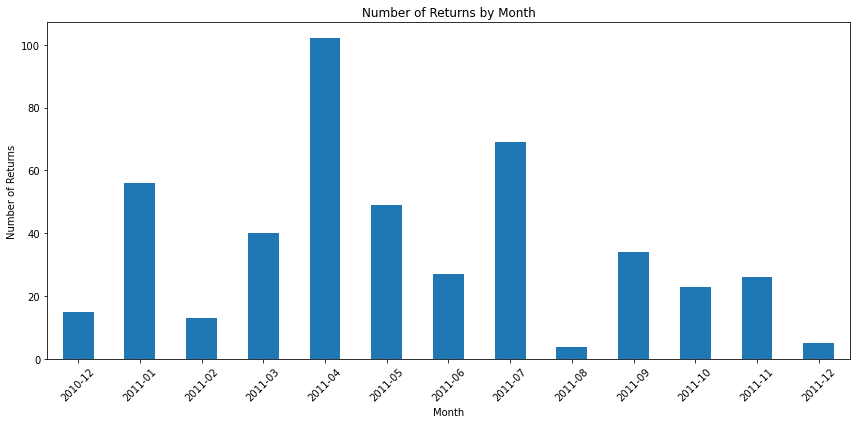

In [601]:
# Visualize returns over time
returns['InvoiceDate'] = pd.to_datetime(returns['InvoiceDate'])
returns['Month'] = returns['InvoiceDate'].dt.to_period('M')
monthly_returns = returns.groupby('Month').size()

plt.figure(figsize=(12, 6))
monthly_returns.plot(kind='bar')
plt.title('Number of Returns by Month')
plt.xlabel('Month')
plt.ylabel('Number of Returns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Seasonal Pattern: There's a clear seasonal pattern in returns, with peaks and troughs throughout the year.
- Highest Returns: The highest number of returns occurred in 2011-04 (April 2011), with over 100 returns. This could be related to post-Easter sales or spring season purchases.
- Second Highest: The second highest peak is in 2011-07 (July 2011), which might be associated with summer sales or vacation-related purchases.
- Lowest Returns: The lowest number of returns is seen in 2011-08 (August 2011), with fewer than 10 returns. This could be due to fewer purchases in late summer or improved product satisfaction during this period.
- Year-End Trend: There's a noticeable increase in returns towards the end of 2010 (2010-11 and 2010-12), possibly related to holiday season purchases.
- Potential Factors: Spikes in returns could be due to various factors such as seasonal sales, product launches, changes in return policies, or quality issues with specific batches of products.
- Variability: There's considerable month-to-month variability, suggesting that return rates are influenced by factors that change throughout the year (e.g., seasonal products, promotional activities).
- Business Implications: The business should prepare for higher return volumes in April and July, and potentially adjust inventory and staffing accordingly.
- Trend: There doesn't appear to be a clear upward or downward trend over the entire period, suggesting that overall return behavior is relatively stable year-over-year.

In [602]:
# Calculate the total value of returns
total_return_value = returns['TotalAmount'].sum()
total_sales_value = df_cleaned[df_cleaned['IsReturn'] == False]['TotalAmount'].sum()
return_rate_by_value = abs(total_return_value) / (total_sales_value + abs(total_return_value))

print(f"\nTotal value of returns: £{abs(total_return_value):.2f}")
print(f"Return rate by value: {return_rate_by_value:.2%}")


Total value of returns: £26.07
Return rate by value: 0.00%


In [603]:
# Comparison of average transaction value: returns vs. regular sales
avg_return_value = returns['TotalAmount'].mean()
avg_sale_value = df_cleaned[df_cleaned['IsReturn'] == False]['TotalAmount'].mean()

print(f"\nAverage return transaction value: £{abs(avg_return_value):.2f}")
print(f"Average sale transaction value: £{avg_sale_value:.2f}")


Average return transaction value: £0.06
Average sale transaction value: £11.71


1. Return Pattern Analysis:
Overall return rate: 0.10%

Top 5 products with highest return rates:
StockCode
82545A    1.0
23064     1.0
37477D    1.0
37477B    1.0
21653     1.0
Name: IsReturn, dtype: float64

Top 5 customers with highest return rates:
CustomerID
Guest      0.003961
16255.0    0.000000
16258.0    0.000000
16260.0    0.000000
16261.0    0.000000
Name: IsReturn, dtype: float64

Impact on total sales:
IsReturn
False    5398602.774
True          26.070
Name: TotalAmount, dtype: float64
Percentage of sales lost to returns: 0.00%


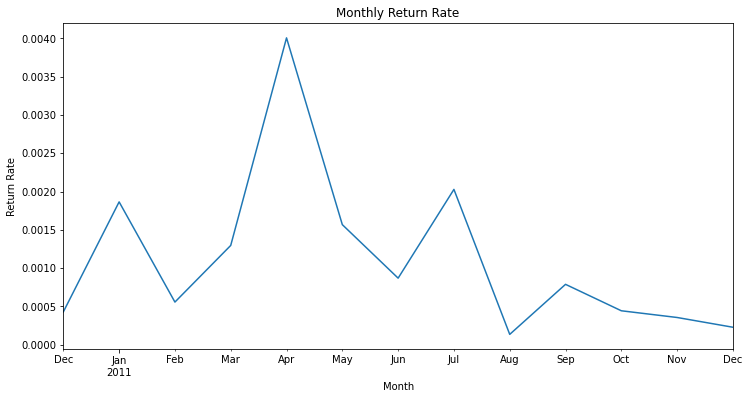

In [604]:
# Analyze return patterns and their impact on sales
def analyze_returns(df):
    print("1. Return Pattern Analysis:")
    
    # Overall return rate
    return_rate = df['IsReturn'].mean() * 100
    print(f"Overall return rate: {return_rate:.2f}%")
    
    # Return rate by product
    product_return_rate = df.groupby('StockCode')['IsReturn'].mean().sort_values(ascending=False)
    print("\nTop 5 products with highest return rates:")
    print(product_return_rate.head())
    
    # Return rate by customer
    customer_return_rate = df.groupby('CustomerID')['IsReturn'].mean().sort_values(ascending=False)
    print("\nTop 5 customers with highest return rates:")
    print(customer_return_rate.head())
    
    # Impact on sales
    sales_impact = df.groupby('IsReturn')['TotalAmount'].sum()
    print("\nImpact on total sales:")
    print(sales_impact)
    print(f"Percentage of sales lost to returns: {sales_impact[True] / sales_impact.sum() * 100:.2f}%")
    
    # Visualize monthly return rate
    df['Month'] = df['InvoiceDate'].dt.to_period('M')
    monthly_return_rate = df.groupby('Month')['IsReturn'].mean()
    
    plt.figure(figsize=(12, 6))
    monthly_return_rate.plot()
    plt.title('Monthly Return Rate')
    plt.xlabel('Month')
    plt.ylabel('Return Rate')
    plt.show()

analyze_returns(df_cleaned)


- Peak Return Rate: The highest return rate occurs in April, reaching about 0.004 (0.4%). This could be related to post-Easter sales or spring season purchases.
- Secondary Peak: There's a smaller peak in July, with a return rate of about 0.002 (0.2%). This might be associated with summer sales or vacation-related purchases.
- Lowest Return Rates: The lowest return rates are observed in August and December, both below 0.0005 (0.05%). This could indicate higher customer satisfaction during these periods or potentially fewer purchases.
- Seasonal Pattern: There's a clear seasonal pattern in return rates, with higher rates in spring and early summer, and lower rates in late summer and winter.
- Year-End Trend: The return rate starts low in December, rises through spring, and then generally declines towards the end of the year, with some fluctuations.
- Variability: There's considerable month-to-month variability, suggesting that return rates are influenced by various factors that change throughout the year.
- Overall Low Return Rate: The return rates are generally low, never exceeding 0.45%, which suggests good overall customer satisfaction or effective policies to minimize returns.
- Potential Factors: Spikes in return rates could be due to various factors such as seasonal product releases, promotional activities, or changes in return policies.
- Business Implications:
    - The business should prepare for higher return volumes in April and July.
    - There may be opportunities to investigate and replicate the conditions leading to low return rates in August and December.


2. Free Products Analysis:
Overall free product rate: 0.30%

Top 5 free products:
35965    12
23084    10
22676     9
22627     8
22683     8
Name: StockCode, dtype: int64

Top 5 customers receiving free products:
Guest      1362
13081.0       4
13985.0       2
12748.0       1
12444.0       1
Name: CustomerID, dtype: int64


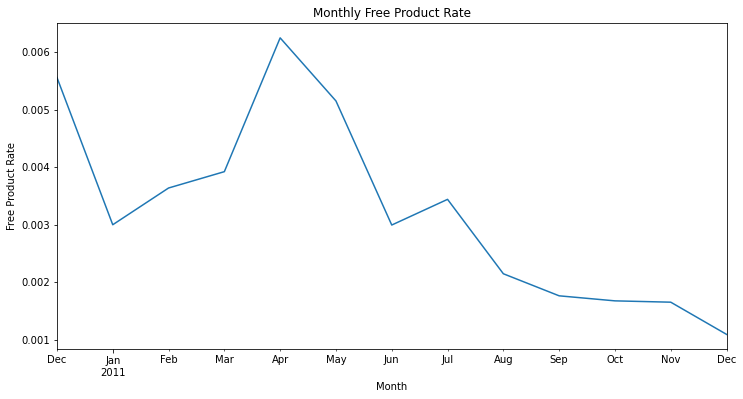

In [605]:
# Investigate free products
def analyze_free_products(df):
    print("\n2. Free Products Analysis:")
    
    # Overall free product rate
    free_rate = df['IsFreeProd'].mean() * 100
    print(f"Overall free product rate: {free_rate:.2f}%")
    
    # Top free products
    free_products = df[df['IsFreeProd']]['StockCode'].value_counts()
    print("\nTop 5 free products:")
    print(free_products.head())
    
    # Customers receiving most free products
    free_product_customers = df[df['IsFreeProd']]['CustomerID'].value_counts()
    print("\nTop 5 customers receiving free products:")
    print(free_product_customers.head())
    
    # Visualize free products over time
    df['Month'] = df['InvoiceDate'].dt.to_period('M')
    monthly_free_rate = df.groupby('Month')['IsFreeProd'].mean()
    
    plt.figure(figsize=(12, 6))
    monthly_free_rate.plot()
    plt.title('Monthly Free Product Rate')
    plt.xlabel('Month')
    plt.ylabel('Free Product Rate')
    plt.show()

analyze_free_products(df_cleaned)

- Peak Free Product Rate: The highest rate of free products occurs in April, reaching about 0.0062 (0.62%). This could be related to spring promotional activities or special offers.
- Secondary Peak: There's a notable peak at the start of the graph in December, with a rate of about 0.0055 (0.55%). This might be associated with holiday season promotions.
- Lowest Rates: The lowest free product rates are observed towards the end of the year, particularly in November and December, dropping below 0.002 (0.2%).
- Seasonal Pattern: There's a clear seasonal pattern in free product distribution, with higher rates in winter and spring, and lower rates in late summer and autumn.
- Gradual Decline: After the peak in April, there's a general downward trend in the free product rate for the rest of the year, with some fluctuations.
- Variability: There's considerable month-to-month variability, suggesting that free product offerings are likely tied to specific marketing strategies or promotional events.
- Year-End Strategy: The high rate in December (start of graph) compared to the low rate in the following December suggests a possible change in promotional strategy year-over-year.
- Potential Factors: Spikes in free product rates could be due to various factors such as new product launches, clearance of old inventory, or customer acquisition campaigns.
- Business Implications:
    - The business appears to use free products more aggressively in the first half of the year.
    - There may be an opportunity to boost sales in the latter part of the year by increasing free product offerings.

- Further Analysis Needed: It would be beneficial to compare this free product rate data with overall sales data and customer acquisition rates to understand the effectiveness of these promotions.
- Strategic Use: The pattern suggests a strategic use of free products, possibly to stimulate sales during slower periods or to complement other marketing initiatives.

- The business could use this data to:
    - Optimize their promotional calendar
    - Align free product offerings with other marketing efforts
    - Evaluate the effectiveness of free product strategies in different seasons
    - Consider adjusting the strategy to potentially boost engagement in slower months


3. Sales Performance Analysis:

Quantity comparison:
Regular Sales:
count    461146.000000
mean          6.179835
std           6.396717
min           1.000000
25%           1.000000
50%           4.000000
75%          10.000000
max          26.000000
Name: Quantity, dtype: float64

Returns:
count    463.000000
mean       5.630670
std        3.888557
min        1.000000
25%        2.000000
50%        5.000000
75%        9.000000
max       14.000000
Name: Quantity, dtype: float64

UnitPrice comparison:
Regular Sales:
count    461146.000000
mean          2.593874
std           1.930783
min           0.001000
25%           1.250000
50%           2.080000
75%           3.750000
max           8.330000
Name: UnitPrice, dtype: float64

Returns:
count    4.630000e+02
mean     1.000000e-02
std      1.180888e-16
min      1.000000e-02
25%      1.000000e-02
50%      1.000000e-02
75%      1.000000e-02
max      1.000000e-02
Name: UnitPrice, dtype: float64

TotalAmount comparison:
Regular Sales:
cou

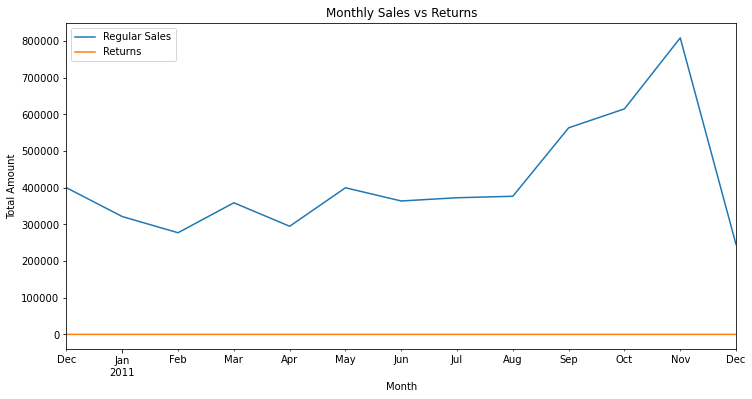

In [606]:
# Separate analysis for regular sales and returns
def analyze_sales_performance(df):
    print("\n3. Sales Performance Analysis:")
    
    # Separate regular sales and returns
    regular_sales = df[~df['IsReturn']]
    returns = df[df['IsReturn']]
    
    # Compare key metrics
    metrics = ['Quantity', 'UnitPrice', 'TotalAmount']
    
    for metric in metrics:
        print(f"\n{metric} comparison:")
        print("Regular Sales:")
        print(regular_sales[metric].describe())
        print("\nReturns:")
        print(returns[metric].describe())
    
    # Visualize sales trends
    monthly_sales = regular_sales.groupby('Month')['TotalAmount'].sum()
    monthly_returns = returns.groupby('Month')['TotalAmount'].sum()
    
    plt.figure(figsize=(12, 6))
    monthly_sales.plot(label='Regular Sales')
    monthly_returns.plot(label='Returns')
    plt.title('Monthly Sales vs Returns')
    plt.xlabel('Month')
    plt.ylabel('Total Amount')
    plt.legend()
    plt.show()

analyze_sales_performance(df_cleaned)


- Sales Trend:
    - Regular sales (blue line) show significant fluctuations throughout the year.
    - There's a notable upward trend in sales from August to November.
    - The peak sales occur in November, reaching about 800,000 units.
    - There's a sharp decline in sales in December, dropping to the lowest point of the year.

- Returns:
    - The returns (orange line) appear to be consistently low throughout the year.
    - The scale of returns is much smaller compared to regular sales, making it almost flat on this graph.

- Seasonal Patterns:
    - Sales seem to be lowest in the early months of the year (January to April).
    - There's a slight increase in sales during May and June.
    - The most significant growth in sales occurs in the latter part of the year (September to November).

- Holiday Season Impact:
    - The dramatic spike in November likely corresponds to holiday shopping (e.g., Black Friday, Cyber Monday).
    - The sharp decline in December could be due to most holiday shopping being completed in November, or it might indicate incomplete data for December.

- Returns vs Sales:
    - Returns appear to be a very small fraction of overall sales throughout the year.
    - There's no visible correlation between higher sales months and higher returns based on this graph.

- Business Implications:
    - The business experiences significant seasonal variation in sales.
    - The last quarter of the year is crucial for the company's revenue.
    - The low return rate relative to sales suggests good customer satisfaction or effective quality control.

- Potential Strategies:
    - Implement marketing campaigns to increase sales during slower months.
    - Ensure adequate inventory and staffing for the high-sales period from September to November.
    - Investigate the possibility of extending the November sales peak into December.

In [607]:
df_cleaned['Month'] = df_cleaned['InvoiceDate'].dt.to_period('M')
monthly_data = df_cleaned.groupby(['Month', 'IsReturn'])['TotalAmount'].sum().unstack()
monthly_data.columns = ['Regular Sales', 'Returns']

In [608]:
monthly_data['Return Rate'] = monthly_data['Returns'] / (monthly_data['Regular Sales'] + monthly_data['Returns'])

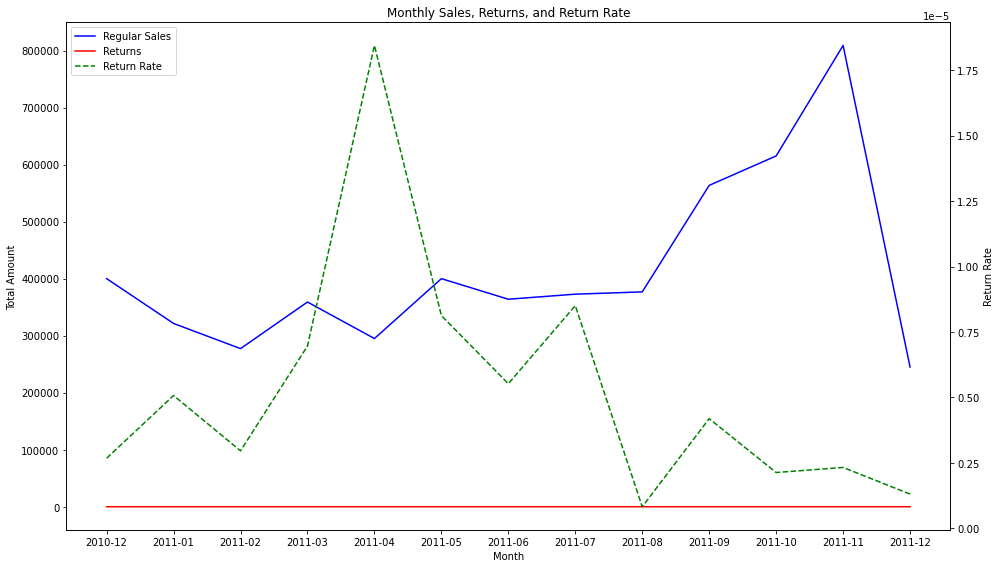

In [609]:
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.set_xlabel('Month')
ax1.set_ylabel('Total Amount')
ax1.plot(monthly_data.index.astype(str), monthly_data['Regular Sales'], color='blue', label='Regular Sales')
ax1.plot(monthly_data.index.astype(str), monthly_data['Returns'], color='red', label='Returns')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Return Rate')
ax2.plot(monthly_data.index.astype(str), monthly_data['Return Rate'], color='green', linestyle='--', label='Return Rate')
ax2.tick_params(axis='y')

# Add labels and title
plt.title('Monthly Sales, Returns, and Return Rate')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()


- Sales Trend (Blue Line):
    - Sales show significant fluctuations throughout the year.
    - There's a notable upward trend from August to November, with peak sales in November.
    - A sharp decline in sales is observed in December.
    - Lower sales are seen in the early months of the year (January to April).

- Returns (Red Line):
    - Returns appear consistently low throughout the year.
    - The scale of returns is much smaller compared to regular sales.

- Return Rate (Green Dotted Line):
    - The return rate fluctuates considerably throughout the year.
    - A significant spike in the return rate occurs in April, despite not having the highest absolute number of returns.
    - The return rate is generally lower in the latter part of the year, especially during peak sales months.

- Seasonal Patterns:
    - Sales are lowest in early months and highest in the fall/winter season.
    - The return rate seems to be higher in spring and early summer.

- Key Observations:
    - The highest return rate doesn't coincide with the highest sales period, suggesting that high sales volume doesn't necessarily lead to a higher return rate.
    - The sharp sales increase in November (likely due to holiday shopping) doesn't correspond to an increase in the return rate.
    - December shows a dramatic drop in sales but doesn't show a corresponding spike in returns or return rate.

- Business Implications:
    - The company experiences significant seasonal variation in sales.
    - Despite fluctuations in the return rate, the absolute number of returns remains relatively low.
    - The last quarter is crucial for revenue, with lower return rates during this high-sales period.

- Areas for Further Investigation:
    - Factors causing the high return rate in April.
    - Reasons for the sharp December sales decline.
    - Strategies to maintain the lower return rates seen during high-sales periods.

- Potential Strategies:
    - Implement targeted quality control or customer education during high return rate periods.
    - Develop marketing strategies to boost sales during slower months.
    - Analyze the factors contributing to lower return rates during peak sales months and apply these insights year-round.

In [610]:
# Summary statistics
print("Summary Statistics:")
monthly_data.describe()

Summary Statistics:


,Regular Sales,Returns,Return Rate
count,13.000000,13.000000,1.300000e+01
mean,415277.136462,2.005385,5.310395e-06
std,157518.572955,1.405570,4.676212e-06
min,245043.030000,0.310000,8.228168e-07
25%,321410.670000,1.070000,2.324172e-06
50%,372754.211000,1.880000,4.187921e-06
75%,400010.440000,2.500000,6.963518e-06
max,808888.410000,5.440000,1.844399e-05


- Sales Performance:
    Strong sales performance with a high average and significant peaks (max over £800,000)
    Considerable variability in monthly sales, indicating seasonality or other cyclical factors

- Returns:
    Very low return values compared to sales
    Highly variable, with some months seeing significantly higher returns than others

- Return Rate:
    Extremely low return rates overall (less than 0.002% even at the maximum)
    Variability in return rates suggests some months have higher return propensity

- Distribution Characteristics:
    All metrics show right-skewed distributions, indicating occasional high-value outliers
    The skewness is most pronounced in Returns, suggesting infrequent but notable return events

- Business Implications:
    Very successful in minimizing returns relative to sales
    Need to investigate factors contributing to peak sales and return months
    Potential for improving consistency in sales performance given the high variability

- Potential Strategies:
    Leverage insights from low-return months to improve overall return rates
    Focus on replicating conditions of peak sales months
    Investigate causes of variability in sales to stabilize performance

In [611]:
# Analyze correlation between sales and returns
correlation = monthly_data['Regular Sales'].corr(monthly_data['Returns'])
print(f"\nCorrelation between Regular Sales and Returns: {correlation:.2f}")


Correlation between Regular Sales and Returns: -0.03


- a) Independence: Sales and returns appear to be independent of each other. Higher sales don't necessarily lead to more returns, and vice versa.
- b) Complex relationship: The lack of correlation doesn't mean there's no relationship at all; it just indicates no linear relationship. There could be non-linear or more complex relationships not captured by this simple correlation.
- c) Other factors: Factors other than sales volume are likely more important in determining the number of returns. These could include product quality, customer satisfaction, or seasonal effects.
- d) Consistent return rate: This might suggest that the return rate is fairly consistent regardless of sales volume, which is generally a positive indicator for the business.


- Business insights:
    - The company seems to manage returns well, as they don't increase proportionally with sales.
    - Quality control and customer satisfaction appear to be consistent across different sales volumes.
    - Marketing or sales strategies to increase sales volume are unlikely to negatively impact returns.


Customer and Product Pattern Analysis:
Top 5 high-value customers and their return/free product rates:
            IsReturn  IsFreeProd  TotalAmount
CustomerID                                   
Guest       0.003961    0.011652    859633.81
14911.0     0.000000    0.000212     91209.34
13089.0     0.000000    0.000000     38565.78
14096.0     0.000000    0.000000     38556.58
17841.0     0.000000    0.000000     33847.34

Top 5 high-volume products and their return/free rates:
           IsReturn  IsFreeProd  Quantity
StockCode                                
21212           0.0    0.000000     16422
84879           0.0    0.000000     14363
85099B          0.0    0.001648     14072
85123A          0.0    0.002100     11603
22197           0.0    0.000000     10865


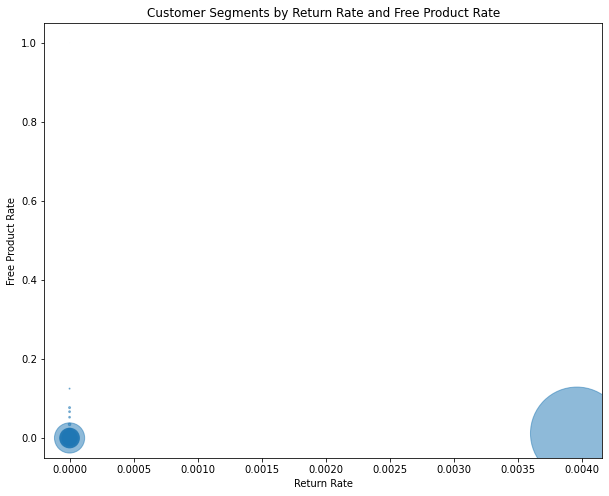

In [612]:
# Analyze customers and products associated with returns and free items
def analyze_customer_product_patterns(df):
    print("\nCustomer and Product Pattern Analysis:")
    
    # Customers with high return rates and free product receipts
    customer_patterns = df.groupby('CustomerID').agg({
        'IsReturn': 'mean',
        'IsFreeProd': 'mean',
        'TotalAmount': 'sum'
    }).sort_values('TotalAmount', ascending=False)
    
    print("Top 5 high-value customers and their return/free product rates:")
    print(customer_patterns.head())
    
    # Products with high return rates and frequently given as free
    product_patterns = df.groupby('StockCode').agg({
        'IsReturn': 'mean',
        'IsFreeProd': 'mean',
        'Quantity': 'sum'
    }).sort_values('Quantity', ascending=False)
    
    print("\nTop 5 high-volume products and their return/free rates:")
    print(product_patterns.head())
    
    # Visualize customer segments
    plt.figure(figsize=(10, 8))
    plt.scatter(customer_patterns['IsReturn'], customer_patterns['IsFreeProd'], 
                s=customer_patterns['TotalAmount']/100, alpha=0.5)
    plt.xlabel('Return Rate')
    plt.ylabel('Free Product Rate')
    plt.title('Customer Segments by Return Rate and Free Product Rate')
    plt.show()

analyze_customer_product_patterns(df_cleaned)

- Concentration of Customers:
The large bubble in the bottom-left corner indicates that a significant majority of customers have very low return rates and low free product rates. This suggests that most of your customers rarely return items and don't frequently receive free products.

- Return Rate Distribution:
The return rates are generally very low, ranging from 0 to about 0.004 (0.4%).
There's a notable cluster of customers with a return rate of around 0.004, represented by the large bubble on the right side of the plot.

- Free Product Rate Distribution:
The free product rates are also very low, mostly concentrated below 0.2 (20%).
There's a slight vertical spread in the free product rate, indicating some variation among customers.

- Outliers:
There are a few small dots scattered above the main cluster, representing customers with slightly higher free product rates but still low return rates.
No significant outliers are visible in terms of extremely high return rates or free product rates.

- Relationship between Return Rate and Free Product Rate:
There doesn't appear to be a strong correlation between return rates and free product rates, as the points don't form a clear diagonal pattern.

- Customer Segments:
The plot effectively shows two main segments:
a. The majority segment with very low return and free product rates.
b. A smaller segment with slightly higher return rates but still low free product rates.

Recommendations:
- Implement a return policy review for products with high return rates.
- Investigate the reasons for returns among top returning customers.
- Optimize free product strategy by analyzing its impact on customer retention and sales.
- Develop targeted marketing campaigns for customer segments based on their return and free product patterns.
- Regularly monitor and adjust inventory based on return rates and free product distributions.
- Consider loyalty programs or incentives for customers with low return rates and high purchase volumes.

- Overall Customer Satisfaction:
The low return rates suggest high customer satisfaction with products or a stringent return policy. This is generally positive for the business.
- Free Product Strategy:
The low free product rates indicate that free products are not frequently used as a marketing or customer retention tool.
- Loyalty Program Potential:
Consider implementing or adjusting a loyalty program that might increase the free product rate for valuable customers, potentially improving retention.
- Product Quality Assurance:
The low return rates suggest good product quality. Maintain this standard to keep customer satisfaction high.
- Customer Behavior Study:
Conduct a deeper analysis of customers with slightly higher free product rates to understand if these are high-value customers or if there's a specific segment benefiting from promotions.

- Key Insights:
    - Guest Purchases: These make up a significant portion of sales but also have the highest return and free product rates. This suggests a potential area for improvement in targeting and customer satisfaction.
    - Loyal Customers: High-value individual customers seem very satisfied, with no returns and minimal free products.
    - Product Quality: The top-selling products have no returns, indicating high quality or customer satisfaction with these items.
    - Free Product Strategy: Free products are used sparingly, even for top-selling items, suggesting a targeted approach to promotions.
    - Return Policy: Overall, return rates are very low, indicating effective quality control and accurate product descriptions.

- Recommendations:
    - Guest Experience: Investigate ways to improve the guest purchase experience to reduce returns and potentially convert guests to registered customers.
    - Loyalty Program: Consider implementing or enhancing a loyalty program to convert more "Guest" purchases into registered customer accounts.
    - Product Expansion: Analyze the characteristics of the top-selling products to inform future product development or inventory decisions.
    - Targeted Promotions: Use the minimal free product distribution as a model for targeted, efficient promotional strategies.
    - Customer Segmentation: Develop marketing and service strategies tailored to different customer segments based on their purchasing behavior and return patterns.

In [613]:
# Numerical variables
numerical_vars = ['Quantity', 'UnitPrice', 'TotalAmount']

In [614]:
# Categorical variables
categorical_vars = ['Country', 'CustomerID']

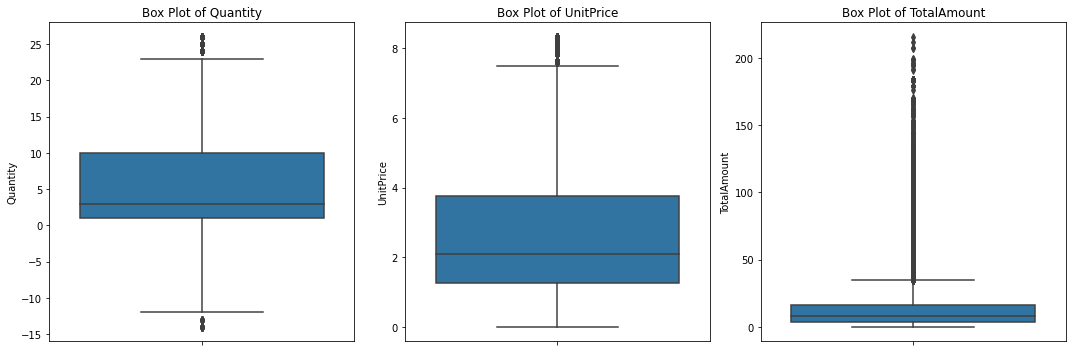

In [615]:
# Box plots
plt.figure(figsize=(15, 5))
for i, var in enumerate(numerical_vars):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[var])
    plt.title(f'Box Plot of {var}')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

- Key Insights:
    - Order Sizes: Most orders are for small quantities (1-10 items), but there are occasional large orders.
    - Product Pricing: Most products are priced between £1.25 and £3.75, with some premium items above £8.
    - Transaction Values: While most transactions are under £20, there are many high-value transactions, some exceeding £200.
    - Returns: The presence of negative quantities indicates that the business handles returns.
    - Pricing Strategy: The business offers a range of price points, from very low (near £0) to premium items.
    - Sales Distribution: The business has a "long tail" of high-value transactions that significantly impact total revenue.

- Business Implications:
    - Inventory Management: Focus on maintaining stock for common order sizes (1-10 units) while being prepared for occasional large orders.
    - Pricing Strategy: The current multi-tiered pricing strategy caters to different customer segments. Consider analyzing the performance of premium-priced items.
    - Customer Behavior: Most customers make small to medium-sized purchases, but there's a segment making very large purchases. This suggests potential for targeted marketing or a VIP program.
    - Returns Policy: The return process seems to be integrated into the business model. Ensure it's efficient and customer-friendly.
    - Revenue Analysis: While focusing on the majority of transactions is important, don't neglect the impact of high-value outliers on overall revenue.
    - Product Mix: Consider the balance between low-priced, high-volume items and high-priced, low-volume items in the product mix.

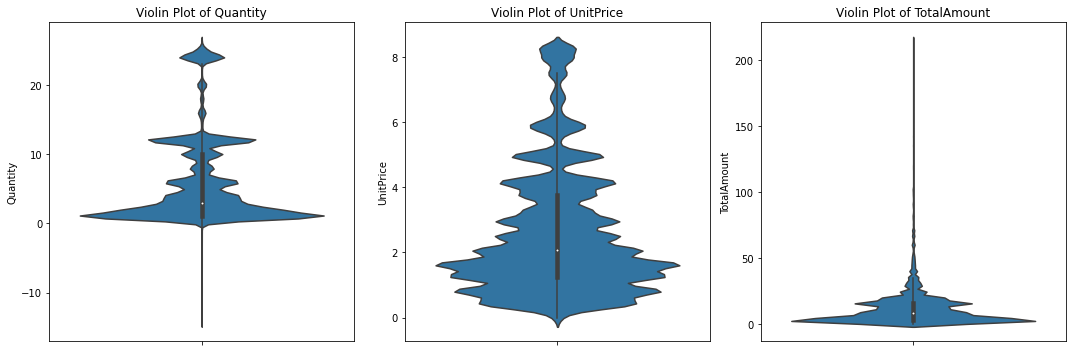

In [616]:
# Violin plots
plt.figure(figsize=(15, 5))
for i, var in enumerate(numerical_vars):
    plt.subplot(1, 3, i+1)
    sns.violinplot(y=df[var])
    plt.title(f'Violin Plot of {var}')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

- Key Insights:

    - Order Patterns:
        - Most orders are for small quantities (1-3 items)
        - Some preference for round numbers (e.g., 10 units)
        - Returns (negative quantities) are relatively rare

    - Pricing Strategy:
        - Clear evidence of price point strategy (e.g., £1.99, £2.99)
        - Multiple distinct price tiers suggest categorized product pricing
        - Majority of items priced under £4

    - Transaction Values:
        - Most transactions are of low value (under £20)
        - A small number of high-value transactions significantly extend the range

- Business Implications:

    - Inventory Management:
        - Focus on stocking for small quantity orders
        - Be prepared for occasional bulk orders (10+ units)

    - Pricing Optimization:
        - Current tiered pricing seems effective; consider analyzing performance at each price point
        - Potential to introduce new price tiers in gaps between current popular points

    - Marketing and Sales:
        - Target marketing for upselling slightly larger quantities (e.g., from 1 to 3 units)
        - Develop strategies to increase the frequency of medium-value transactions

    - Customer Segmentation:
        - Distinct groups based on purchase quantity and total spend
        - Tailor approaches for high-volume, low-price customers vs. low-volume, high-price customers

    - Product Development:
        - Consider introducing products or bundles at price points that fill gaps in the current distribution

    - Revenue Analysis:
        - While focusing on the common low-value transactions, don't neglect the impact of rare high-value sales

    - Return Policy:
        - Current return rate seems low; ensure the policy continues to support this trend

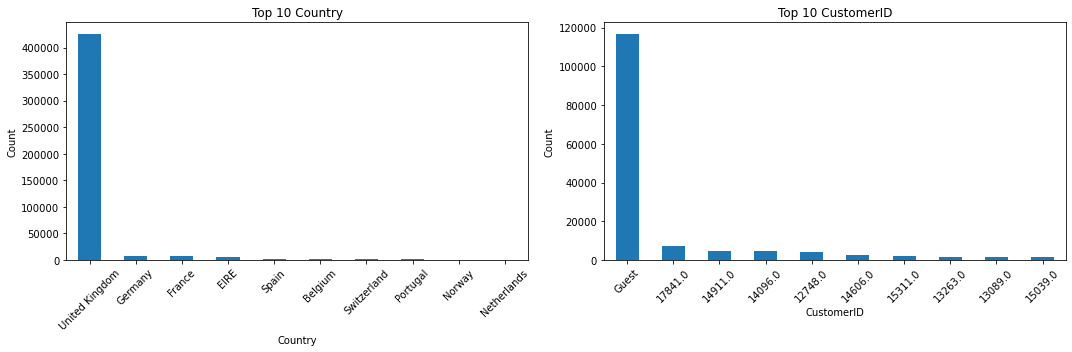

In [617]:
# Bar plots for top categories
plt.figure(figsize=(15, 5))
for i, var in enumerate(categorical_vars):
    plt.subplot(1, 2, i+1)
    df[var].value_counts().head(10).plot(kind='bar')
    plt.title(f'Top 10 {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Key Insights:

  - Market Focus:
    - The business is heavily UK-centric, possibly a UK-based company with some international reach.
    - There's potential for growth in other European markets, particularly Germany, France, and Ireland.

  - Customer Behavior:
    - A large portion of transactions are from unregistered "Guest" customers.
    - There's a core group of highly active customers (top 10 shown), but their transaction volumes vary significantly.

  - Business Model:
    - The high number of guest transactions suggests an accessible, possibly e-commerce platform that doesn't require registration for purchases.
    - The presence of high-volume individual customers indicates a loyalty program or B2B component.

  - Growth Opportunities:
    - Converting guest customers to registered accounts could be a significant opportunity.
    - Expanding marketing efforts in secondary markets (Germany, France, Ireland) might yield growth.

  - Customer Segmentation:
    - Clear segmentation between casual (guest) shoppers and regular, high-volume customers.
    - Potential for targeted marketing strategies for different customer segments.

  - International Strategy:
    - Current international presence suggests potential for further expansion, but it's currently a small part of the business.

- Recommendations:
    - Develop strategies to convert guest shoppers into registered customers.
    - Investigate the characteristics of top individual customers to identify and nurture similar high-value clients.
    - Consider targeted expansion efforts in Germany, France, and Ireland to build on existing presence.
    - Analyze the reasons for success in the UK market and evaluate if these can be replicated in other countries.
    - Implement or enhance a loyalty program to encourage repeat business from registered customers.
    - Conduct market research in lower-volume countries to identify barriers to growth and potential opportunities.



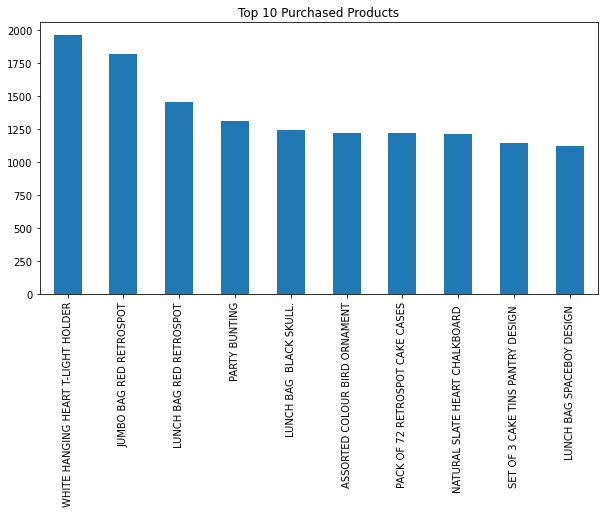

In [618]:
df_cleaned['Description'].value_counts().head(10).plot(kind='bar', figsize=(10, 5))
plt.title('Top 10 Purchased Products')
plt.show()

- Key Insights:
    - Home Decor Focus: Many of the top items are related to home decoration or lighting, suggesting this is a strong category for the business.
    - Gift-Oriented Products: Several items (e.g., heart-shaped holder, bunting) seem suitable as gifts, indicating a significant gift-buying customer base.
    - Design Popularity: The recurring "Retrospot" design suggests customers have a preference for this particular style.
    - Practical and Decorative Mix: The list includes both practical items (lunch bags, cake tins) and purely decorative ones, showing a balance in customer preferences.
    - Color Preferences: Red and white are mentioned explicitly in several top items, potentially indicating color trends among customers.

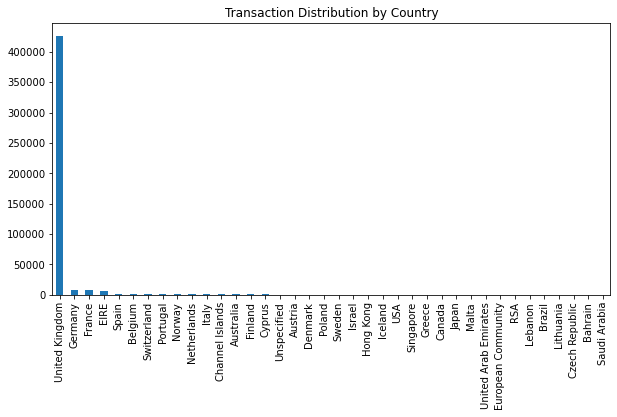

In [619]:
df_cleaned['Country'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Transaction Distribution by Country')
plt.show()

- Market Concentration: The business is heavily concentrated in the UK market. This could be a strength (strong home market) or a risk (over-reliance on one market).
- Expansion Opportunities: There's significant potential for growth in the secondary markets (Germany, France, Ireland) and other European countries.
- International Strategy: The company has established a presence in various international markets, but most are underdeveloped compared to the UK.
- Supply Chain and Logistics: The distribution of transactions suggests a need for a robust logistics network within the UK and an evolving international shipping strategy.
- Marketing and Localization: There may be opportunities to increase market share in secondary and tertiary markets through targeted marketing and localization efforts.
- Product Preferences: Different transaction volumes might reflect varying product preferences or market fit across countries.
- Currency and Pricing Strategies: With a diverse set of markets, the company might need to consider multi-currency pricing and country-specific pricing strategies.
- Regulatory Compliance: Operating in multiple countries requires adherence to various regulatory frameworks, especially considering the European focus.
- Customer Support: The diverse geographic spread suggests a need for multi-lingual customer support and potentially different support strategies for high-volume versus low-volume countries.

### Bivariate Analysis

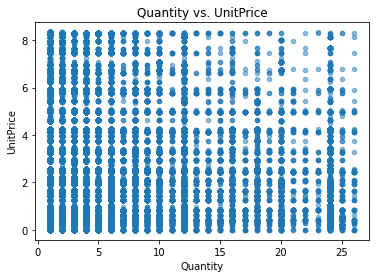

In [620]:
df_cleaned.plot(kind='scatter', x='Quantity', y='UnitPrice', alpha=0.5)
plt.title('Quantity vs. UnitPrice')
plt.show()

- Price Range: The UnitPrice ranges from close to 0 up to about 8 currency units (likely pounds or euros).
- Quantity Range: The Quantity axis extends from 0 to about 25-26 units.
- Price Clustering: There are clear horizontal lines in the plot, indicating common price points. This suggests a tiered pricing strategy.
- Quantity Clustering: Vertical lines are visible, particularly at whole number quantities (1, 2, 3, etc.), indicating that orders often come in round numbers.
- Density: The plot is densest in the lower left corner, suggesting that most transactions involve lower quantities at lower price points.
- Spread: As quantity increases, there's a wider spread of prices, but fewer data points overall.
- Outliers: There are some outliers with high quantities (20+) across various price points.
- Price-Quantity Relationship: There doesn't appear to be a strong correlation between price and quantity. High-priced items are bought in both small and large quantities, as are low-priced items.
- Discrete Nature: The plot shows a discrete pattern, especially for quantity, reflecting the nature of product orders.

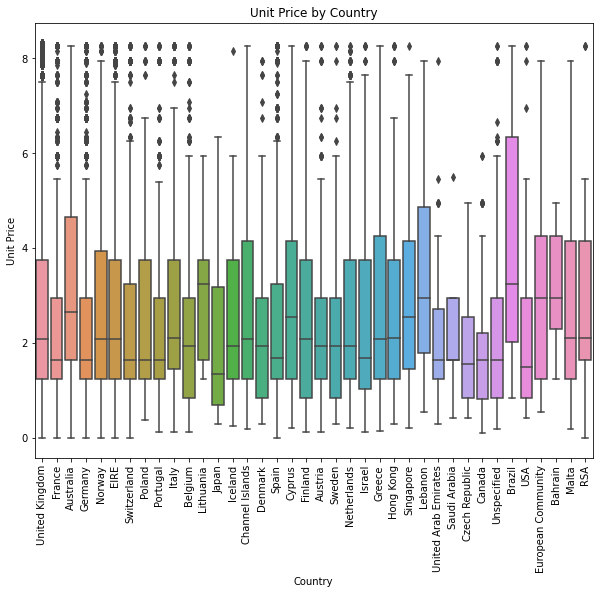

In [621]:
# Box plot: 'Country' vs 'UnitPrice'
plt.figure(figsize=(10, 8))
sns.boxplot(x='Country', y='UnitPrice', data=df_cleaned)
plt.title('Unit Price by Country')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Unit Price')
plt.show()

Key insights:
- Standardized Pricing: The consistency across countries suggests a relatively standardized pricing strategy, possibly with currency conversions accounting for some differences.
- Premium Products: All markets seem to have capacity for premium-priced items, as evidenced by the numerous outliers.
- Market-Specific Analysis: For countries with larger boxes or unusual distributions (e.g., European Community, Bahrain), conduct deeper analysis to understand the factors at play.
- Pricing Strategy Review: Given the consistency, review if there are opportunities for more nuanced, market-specific pricing to optimize revenue.
- Outlier Investigation: Analyze the nature of the high-priced outliers. Are these consistent across markets? Do they represent opportunity for expansion?
- Volume vs. Premium: The data suggests a business model focused on higher-volume, lower-priced items with some premium offerings. Consider if this balance is optimal for each market.
- Currency Effects: Ensure the analysis accounts for currency exchange rates, as this could be influencing the apparent consistency across markets.


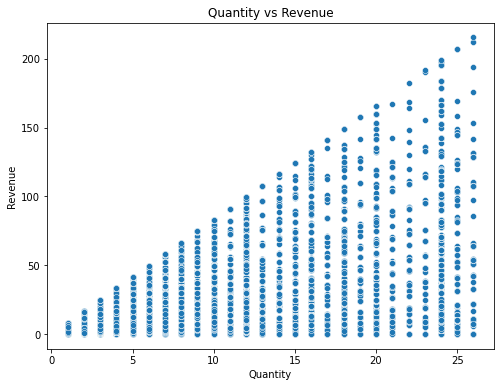

In [622]:
# Revenue calculation
df_cleaned['Revenue'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

# Scatter plot: Quantity vs Revenue
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Quantity', y='Revenue', data=df_cleaned)
plt.title('Quantity vs Revenue')
plt.xlabel('Quantity')
plt.ylabel('Revenue')
plt.show()

- Positive Correlation: There's a clear positive correlation between Quantity and Revenue, as expected. As the quantity of items purchased increases, so does the revenue.
- Non-Linear Relationship: The relationship isn't perfectly linear. As quantity increases, there's more variability in revenue, creating a fan-like shape.
- Discrete Quantities: The plot shows clear vertical lines, indicating that quantities are discrete values (whole numbers), which is typical for retail transactions.
- Revenue Spread: For any given quantity, there's a range of possible revenue values, indicating variation in unit prices or mix of products sold.
- High-Value Transactions: There are some high-revenue transactions (over 150 units of currency) across various quantities, but they become more frequent at higher quantities.
- Low-Value, High-Quantity: There are also transactions with high quantities but relatively low revenue, suggesting some products are sold in bulk at lower unit prices.
- Maximum Quantity: The plot extends to about 25-26 units on the quantity axis, suggesting this is the maximum order size in the dataset.
- Density: The plot is densest in the lower quantities (1-10 range), indicating that most transactions involve smaller quantities.
- Outliers: There are some outlier points, particularly at higher quantities, that generate significantly more revenue than typical transactions of that quantity.

Business Implications and Recommendations:
- Pricing Strategy: Review pricing strategies for high-quantity purchases. Consider if bulk discounts are appropriate or if they're possibly too steep in some cases.
- Product Mix Analysis: Investigate the products that contribute to high-revenue transactions across different quantities to understand which items drive value.
- Upselling Opportunities: For transactions in the lower quantity range, explore opportunities to encourage customers to purchase additional items.
- Customer Segmentation: Analyze if the high-revenue, high-quantity transactions come from specific customer segments (e.g., B2B customers) and tailor strategies accordingly.
- Inventory Management: Use this data to optimize inventory levels, ensuring sufficient stock for both popular low-quantity purchases and less frequent high-quantity orders.
- Marketing Strategies: Develop targeted marketing campaigns for different quantity-revenue segments, perhaps encouraging movement from lower to higher quantity purchases.
- Profit Margin Analysis: Investigate the profit margins across different quantity-revenue combinations to ensure that high-volume sales are sufficiently profitable.
- Order Size Limits: Consider if the maximum order size (around 25-26 units) is a deliberate limit or if there's potential to accommodate and encourage larger orders.
- Customer Behavior Insights: Use this data to understand typical purchasing patterns and identify unusual or changing customer behaviors.
- Promotional Planning: Design promotions that encourage customers to increase their purchase quantities, especially in the mid-range where there's potential for revenue growth.

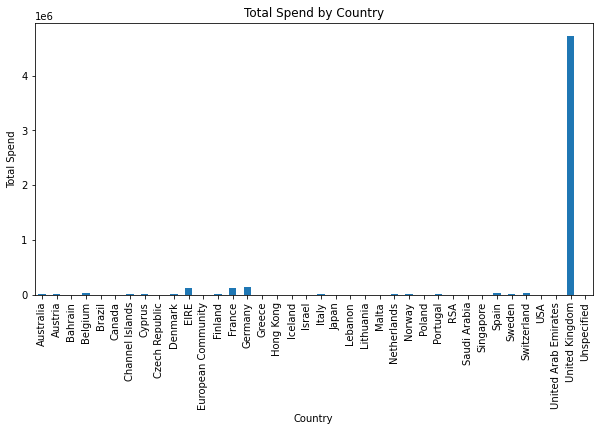

In [623]:
df_cleaned['TotalSpend'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']
country_spend = df_cleaned.groupby('Country')['TotalSpend'].sum()
country_spend.plot(kind='bar', figsize=(10, 5))
plt.title('Total Spend by Country')
plt.xlabel('Country')
plt.ylabel('Total Spend')
plt.show()

key insights:
- Dominant Market: The United Kingdom overwhelmingly dominates total spend, with approximately £4.5 million in sales. This is significantly higher than any other country.
- Secondary Markets: There are a few countries with noticeable, but much smaller, total spend amounts. These include:
    Netherlands
    Ireland (EIRE)
    Germany
    France
    Australia

- Long Tail: Many countries show very small total spend amounts, forming a long tail in the distribution.
- Market Concentration: The vast majority of revenue is concentrated in a single market (UK), with minimal international diversification.
- European Presence: Most of the countries with visible spend are European, suggesting a focus on or easier access to European markets.
- Global Reach: The presence of countries like Australia and the USA indicates some level of global reach, albeit with much lower sales volumes.

Key Business Implications and Recommendations:
- Market Dependency: There's a heavy reliance on the UK market. While this shows strong domestic performance, it also presents a risk if the UK market faces economic challenges.
- Expansion Opportunities: There's significant potential for growth in secondary markets, particularly in Europe where some presence is already established.
- International Strategy: Develop targeted strategies to grow sales in countries showing some traction (e.g., Netherlands, Ireland, Germany, France).
- Risk Mitigation: Consider diversifying the customer base internationally to reduce dependence on a single market.
- Market Analysis: Investigate factors contributing to success in the UK and assess if these can be replicated in other markets.
- Resource Allocation: While maintaining strength in the UK, allocate resources to develop promising international markets.
- Localization Efforts: Invest in localization of products, marketing, and customer service for key secondary markets to drive growth.
- Supply Chain Optimization: Review the supply chain to ensure efficient distribution to international markets, potentially setting up regional hubs.
- Regulatory Compliance: Ensure compliance with international trade regulations and tax laws as the business expands globally.
- Cultural Adaptation: Adapt product offerings and marketing strategies to suit local preferences in target expansion markets.
- Partnerships: Consider strategic partnerships or acquisitions in key international markets to accelerate growth.

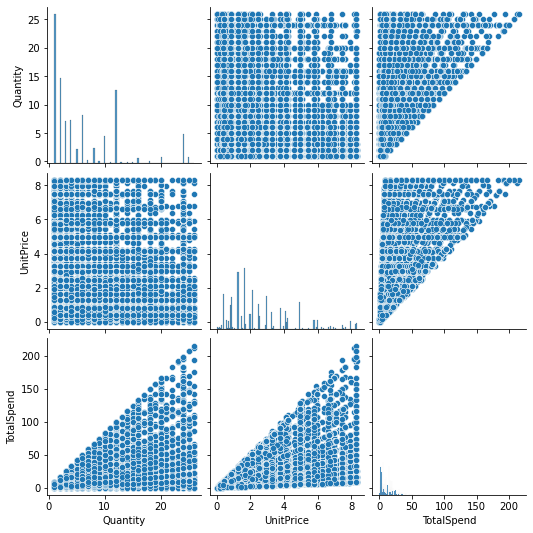

In [624]:
sns.pairplot(df_cleaned[['Quantity', 'UnitPrice', 'TotalSpend']])
plt.show()

Key Insights:
- Pricing strategy appears tiered with distinct price points
- Most orders are for small quantities, but large orders contribute significantly to total spend
- Wide range of unit prices, but most items are relatively low-priced
- Total spend has high variability, influenced by both quantity and unit price
- No strong relationship between quantity and unit price, suggesting consistent pricing regardless of order size

Business Implications:
- Focus on increasing order sizes could significantly boost revenue
- Review bulk discount policies, as larger quantities don't seem to get lower prices
- Analyze high-value transactions to understand and potentially replicate their characteristics
- Consider strategies to shift the distribution of total spend towards higher values
- Evaluate the effectiveness of the current tiered pricing strategy
- Investigate opportunities to upsell or cross-sell to increase average order value

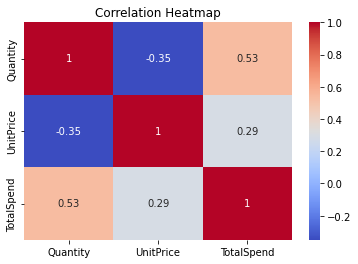

In [625]:
corr = df_cleaned[['Quantity', 'UnitPrice', 'TotalSpend']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Key Insights:
- Quantity is the strongest driver of TotalSpend, more so than UnitPrice.
- There's a slight tendency for unit prices to decrease with larger quantities, but this effect is weak.
- UnitPrice has a positive but weak relationship with TotalSpend, indicating that higher-priced items do contribute to higher total spend, but not as much as quantity.

Business Implications:
- Focus on increasing order quantities could be more effective in boosting revenue than raising prices.
- The weak negative correlation between Quantity and UnitPrice suggests that the current bulk discount strategy, if any, is modest. There might be room to adjust this strategy.
- Given the moderate correlation between Quantity and TotalSpend, strategies to encourage larger order sizes could be particularly effective.
- The weak correlation between UnitPrice and TotalSpend suggests that premium pricing strategies should be carefully considered and might not be the primary driver of revenue.
- Cross-selling and upselling strategies could be effective in increasing both quantity and total spend.
- Customer segmentation strategies could be developed based on their tendency to buy in larger quantities versus their preference for higher-priced items.

### Hypothesis Testing

#### 1. Customer Behavior: Purchase Frequency vs Average Transaction Value

In [626]:
# Calculate purchase frequency and average transaction value for each customer
customer_metrics = df_cleaned.groupby('CustomerID').agg({
    'InvoiceNo': 'count',
    'TotalAmount': 'mean'
})
customer_metrics.columns = ['PurchaseFrequency', 'AvgTransactionValue']

In [627]:
# 1. Customer Behavior: Purchase Frequency vs Average Transaction Value
print("1. Purchase Frequency vs Average Transaction Value")
print("H0: There is no correlation between purchase frequency and average transaction value")
print("H1: There is a significant correlation between purchase frequency and average transaction value")

customer_metrics = df_cleaned.groupby('CustomerID').agg({
    'InvoiceNo': 'count',
    'TotalAmount': 'mean'
})
customer_metrics.columns = ['PurchaseFrequency', 'AvgTransactionValue']

correlation, p_value = stats.pearsonr(customer_metrics['PurchaseFrequency'], 
                                      customer_metrics['AvgTransactionValue'])
print()
print(f"Correlation: {correlation}, p-value: {p_value}")
if p_value < 0.05:
    print("Conclusion: Reject H0. There is a significant correlation between purchase frequency and average transaction value.")
else:
    print("Conclusion: Fail to reject H0. There is not enough evidence to conclude a significant correlation.")

1. Purchase Frequency vs Average Transaction Value
H0: There is no correlation between purchase frequency and average transaction value
H1: There is a significant correlation between purchase frequency and average transaction value

Correlation: -0.027185463353072283, p-value: 0.07820442451671647
Conclusion: Fail to reject H0. There is not enough evidence to conclude a significant correlation.


- Insight: There is not enough evidence to support a significant correlation between purchase frequency and average transaction value. This suggests that increasing the number of purchases does not necessarily lead to a higher average transaction value, indicating that customer spending patterns may be independent of how often they shop.

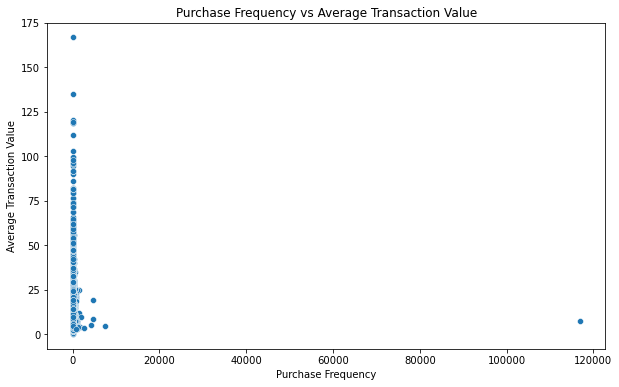

In [628]:
# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PurchaseFrequency', y='AvgTransactionValue', data=customer_metrics)
plt.title('Purchase Frequency vs Average Transaction Value')
plt.xlabel('Purchase Frequency')
plt.ylabel('Average Transaction Value')
plt.show()

#### 2. Product Performance: Sales Volumes Across Categories

In [629]:
print("\n2. Product Category Performance")
print("H0: The mean sales volume is the same across all product categories")
print("H1: At least one product category has a different mean sales volume")

df_cleaned['Category'] = df_cleaned['StockCode'].str[:2] 
f_statistic, p_value = stats.f_oneway(*[group['Quantity'].values for name, group in df_cleaned.groupby('Category')])

print()
print(f"F-statistic: {f_statistic}, p-value: {p_value}")
if p_value < 0.05:
    print("Conclusion: Reject H0. There are significant differences in sales volumes across product categories.")
else:
    print("Conclusion: Fail to reject H0. There is not enough evidence to conclude differences in sales volumes across categories.")


2. Product Category Performance
H0: The mean sales volume is the same across all product categories
H1: At least one product category has a different mean sales volume

F-statistic: 179.35080000550133, p-value: 0.0
Conclusion: Reject H0. There are significant differences in sales volumes across product categories.


- Insight: There are significant differences in sales volumes across product categories. This implies that some product categories perform better than others, which can help in targeted marketing and inventory management strategies.

In [630]:
# 3. Pricing Strategy: Unit Price vs Quantity Sold
print("\n3. Unit Price vs Quantity Sold")
print("H0: There is no correlation between unit price and quantity sold")
print("H1: There is a significant correlation between unit price and quantity sold")

correlation, p_value = stats.pearsonr(df_cleaned['UnitPrice'], df_cleaned['Quantity'])

print()
print(f"Correlation: {correlation}, p-value: {p_value}")
if p_value < 0.05:
    print("Conclusion: Reject H0. There is a significant correlation between unit price and quantity sold.")
else:
    print("Conclusion: Fail to reject H0. There is not enough evidence to conclude a significant correlation.")


3. Unit Price vs Quantity Sold
H0: There is no correlation between unit price and quantity sold
H1: There is a significant correlation between unit price and quantity sold

Correlation: -0.3495098658867638, p-value: 0.0
Conclusion: Reject H0. There is a significant correlation between unit price and quantity sold.


- Insight: A significant negative correlation indicates that as unit prices increase, the quantity sold tends to decrease. This finding can inform pricing strategies; if the goal is to boost sales volume, it may be necessary to reconsider pricing for certain items.

In [631]:
# 4. Seasonal Trends: Sales Volume Across Months
print("\n4. Seasonal Trends")
print("H0: The mean sales volume is the same across all months")
print("H1: At least one month has a different mean sales volume")

df_cleaned['Month'] = df_cleaned['InvoiceDate'].dt.month
f_statistic, p_value = stats.f_oneway(*[group['Quantity'].values for name, group in df_cleaned.groupby('Month')])

print()
print(f"F-statistic: {f_statistic}, p-value: {p_value}")
if p_value < 0.05:
    print("Conclusion: Reject H0. There are significant differences in sales volumes across months.")
else:
    print("Conclusion: Fail to reject H0. There is not enough evidence to conclude differences in sales volumes across months.")


4. Seasonal Trends
H0: The mean sales volume is the same across all months
H1: At least one month has a different mean sales volume

F-statistic: 248.42497992263046, p-value: 0.0
Conclusion: Reject H0. There are significant differences in sales volumes across months.


- Insight: There are significant differences in sales volumes across months, suggesting that certain times of the year lead to higher sales. This can guide promotional campaigns and inventory stocking decisions based on seasonal demand.

In [632]:
# 5. Geographical Differences: Transaction Values Across Countries
print("\n5. Geographical Differences")
print("H0: The mean transaction value is the same across all countries")
print("H1: At least one country has a different mean transaction value")

f_statistic, p_value = stats.f_oneway(*[group['TotalAmount'].values for name, group in df_cleaned.groupby('Country')])

print()
print(f"F-statistic: {f_statistic}, p-value: {p_value}")
if p_value < 0.05:
    print("Conclusion: Reject H0. There are significant differences in transaction values across countries.")
else:
    print("Conclusion: Fail to reject H0. There is not enough evidence to conclude differences in transaction values across countries.")


5. Geographical Differences
H0: The mean transaction value is the same across all countries
H1: At least one country has a different mean transaction value

F-statistic: 387.6595628243315, p-value: 0.0
Conclusion: Reject H0. There are significant differences in transaction values across countries.


- Insight: Significant differences in transaction values across countries indicate varying customer behaviors and economic conditions. This can inform market expansion strategies and localized marketing efforts.

In [633]:
# 6. Return Behavior: Return Rates Across Product Categories
print("\n6. Return Rates Across Categories")
print("H0: The return rate is independent of product category")
print("H1: The return rate is dependent on product category")

chi2, p_value, dof, expected = stats.chi2_contingency(pd.crosstab(df_cleaned['Category'], df_cleaned['IsReturn']))

print()
print(f"Chi-square statistic: {chi2}, p-value: {p_value}")
if p_value < 0.05:
    print("Conclusion: Reject H0. There is a significant relationship between product category and return rate.")
else:
    print("Conclusion: Fail to reject H0. There is not enough evidence to conclude a relationship between category and return rate.")


6. Return Rates Across Categories
H0: The return rate is independent of product category
H1: The return rate is dependent on product category

Chi-square statistic: 4967.835032754457, p-value: 0.0
Conclusion: Reject H0. There is a significant relationship between product category and return rate.


- Insight: There is a significant relationship between product category and return rate. This suggests that some categories may have higher return rates, which could indicate issues with product quality or customer expectations, warranting further investigation.

In [634]:
# 7. Time of Purchase: Transaction Value vs Time of Day
print("\n7. Time of Purchase")
print("H0: The mean transaction value is the same across all hours of the day")
print("H1: At least one hour has a different mean transaction value")

df_cleaned['HourOfDay'] = df_cleaned['InvoiceDate'].dt.hour
f_statistic, p_value = stats.f_oneway(*[group['TotalAmount'].values for name, group in df_cleaned.groupby('HourOfDay')])

print()
print(f"F-statistic: {f_statistic}, p-value: {p_value}")
if p_value < 0.05:
    print("Conclusion: Reject H0. There are significant differences in transaction values across hours of the day.")
else:
    print("Conclusion: Fail to reject H0. There is not enough evidence to conclude differences in transaction values across hours.")



7. Time of Purchase
H0: The mean transaction value is the same across all hours of the day
H1: At least one hour has a different mean transaction value

F-statistic: 1105.189048081346, p-value: 0.0
Conclusion: Reject H0. There are significant differences in transaction values across hours of the day.


- Insight: Significant differences in transaction values across hours indicate specific peak times for sales. Businesses can optimize staffing and marketing efforts around these peak times to maximize revenue.

In [635]:
# 8. Order Size and Returns
print("\n8. Order Size and Returns")
print("H0: There is no difference in order size between returned and non-returned orders")
print("H1: There is a significant difference in order size between returned and non-returned orders")

df_cleaned['OrderSize'] = df_cleaned.groupby('InvoiceNo')['Quantity'].transform('sum')
t_statistic, p_value = stats.ttest_ind(df_cleaned[df_cleaned['IsReturn']]['OrderSize'], 
                                       df_cleaned[~df_cleaned['IsReturn']]['OrderSize'])

print()
print(f"T-statistic: {t_statistic}, p-value: {p_value}")
if p_value < 0.05:
    print("Conclusion: Reject H0. There is a significant difference in order size between returned and non-returned orders.")
else:
    print("Conclusion: Fail to reject H0. There is not enough evidence to conclude a difference in order size for returns.")


8. Order Size and Returns
H0: There is no difference in order size between returned and non-returned orders
H1: There is a significant difference in order size between returned and non-returned orders

T-statistic: -19.29195245060388, p-value: 6.767156048934236e-83
Conclusion: Reject H0. There is a significant difference in order size between returned and non-returned orders.


- Insight: There is a significant difference in order size between returned and non-returned orders. This suggests that larger orders may have higher return rates, indicating potential issues with customer satisfaction or product fit.

In [636]:
# 9. Customer Retention: Returns vs Retention
print("\n9. Returns vs Retention")
print("H0: There is no association between making returns and customer retention")
print("H1: There is a significant association between making returns and customer retention")

customer_returns = df_cleaned.groupby('CustomerID')['IsReturn'].any()
customer_retention = df_cleaned.groupby('CustomerID')['InvoiceDate'].max() > df_cleaned['InvoiceDate'].max() - pd.Timedelta(days=90)

contingency_table = pd.crosstab(customer_returns, customer_retention)
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print()
print(f"Chi-square statistic: {chi2}, p-value: {p_value}")
if p_value < 0.05:
    print("Conclusion: Reject H0. There is a significant association between making returns and customer retention.")
else:
    print("Conclusion: Fail to reject H0. There is not enough evidence to conclude an association between returns and retention.")


9. Returns vs Retention
H0: There is no association between making returns and customer retention
H1: There is a significant association between making returns and customer retention

Chi-square statistic: 0.0, p-value: 1.0
Conclusion: Fail to reject H0. There is not enough evidence to conclude an association between returns and retention.


- Insight: There is not enough evidence to conclude an association between returns and retention. This suggests that returns may not significantly impact whether customers continue to shop with the company, indicating a robust customer base or effective return policies.

Overall Insights:
- Strategic Focus: The results highlight areas where strategic interventions could lead to improved sales and customer satisfaction, such as focusing on high-performing product categories, understanding seasonal trends, and managing pricing strategies effectively.
- Customer Behavior: The correlations suggest that pricing and purchase behavior are intertwined, and understanding these dynamics could enhance sales strategies.
- Return Management: The insights on return rates and their relationship with product categories indicate a need for quality control measures and perhaps better customer education on products.

In [637]:
customer_features = df_cleaned.groupby('CustomerID').agg(
    AverageDaysBetweenPurchases=('InvoiceDate', lambda x: (x.max() - x.min()).days / (x.nunique() - 1) if x.nunique() > 1 else 0),
    PreferredShoppingDay=('InvoiceDate', lambda x: x.dt.day_name().mode()[0]),
    PeakShoppingHour=('InvoiceDate', lambda x: x.dt.hour.mode()[0])
).reset_index()

In [638]:
df_cleaned = pd.merge(df_cleaned, customer_features, on='CustomerID', how='left')

In [639]:
df_cleaned[['CustomerID', 'AverageDaysBetweenPurchases', 'PreferredShoppingDay', 'PeakShoppingHour']].head()

,CustomerID,AverageDaysBetweenPurchases,PreferredShoppingDay,PeakShoppingHour
0,17850.0,0.03125,Thursday,9
1,17850.0,0.03125,Thursday,9
2,17850.0,0.03125,Thursday,9
3,17850.0,0.03125,Thursday,9
4,17850.0,0.03125,Thursday,9


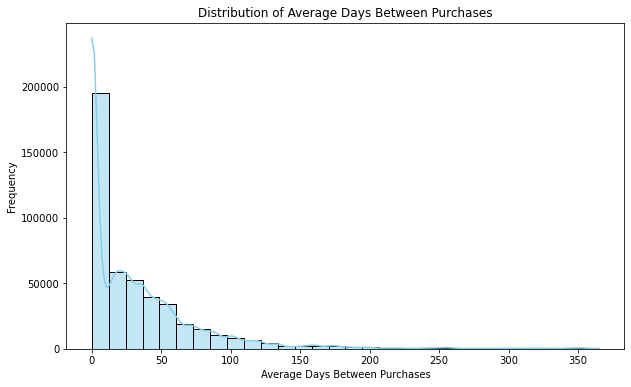

In [640]:
# Graph 1: Distribution of Average Days Between Purchases
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['AverageDaysBetweenPurchases'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Average Days Between Purchases')
plt.xlabel('Average Days Between Purchases')
plt.ylabel('Frequency')
plt.show()

- Frequency of purchases: There's a very high peak at the left side of the graph, indicating that a large number of customers make purchases with very short intervals between them.
- Short purchase cycles: The highest bar is at or near 0 days, suggesting many customers make repeat purchases on the same day or within a few days.
- Rapid decline: There's a sharp drop-off in frequency as the number of days between purchases increases, showing that fewer customers have longer intervals between purchases.
- Long tail: The distribution has a long tail extending to around 350 days, indicating some customers only make purchases about once a year.

Customer segmentation: 
- This graph suggests there are distinct customer segments:
- Frequent shoppers (0-30 days between purchases)
- Regular shoppers (30-100 days between purchases)
- Occasional shoppers (100-200 days between purchases)
- Rare shoppers (200+ days between purchases)

Retention opportunities: 
- There's potential to convert customers with longer purchase intervals into more frequent shoppers through targeted marketing and loyalty programs.
- Inventory planning: This data can help with inventory management, as it shows how often customers are likely to return for new purchases.
- Marketing strategy: Campaigns could be tailored to different segments based on their typical purchase frequency.
- Customer lifetime value: Customers with shorter intervals between purchases likely have higher lifetime values and may warrant more investment in retention efforts.
- Seasonal patterns: The long tail might indicate yearly shoppers, possibly suggesting some seasonal purchasing behavior.
- Business model insights: This pattern might reflect a business with a mix of consumable products (frequently purchased) and durable goods (purchased less often).

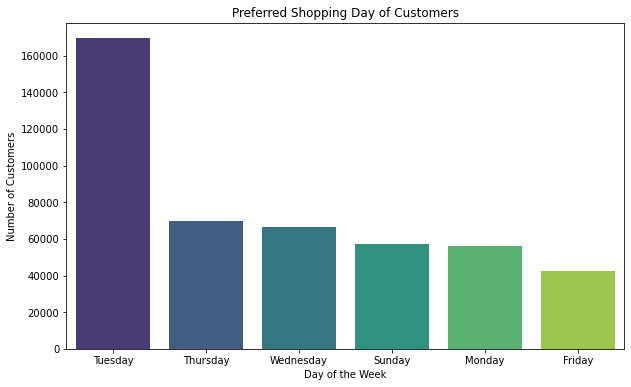

In [641]:
# Graph 2: Preferred Shopping Day of Customers
plt.figure(figsize=(10, 6))
preferred_day_counts = df_cleaned['PreferredShoppingDay'].value_counts()
sns.barplot(x=preferred_day_counts.index, y=preferred_day_counts.values, palette='viridis')
plt.title('Preferred Shopping Day of Customers')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Customers')
plt.show()

- Tuesday is by far the most popular shopping day, with more than double the customers of any other day.
- The middle of the week (Tuesday-Thursday) seems to be favored for shopping.
- Friday, typically considered part of the weekend, is actually the least popular day for shopping according to this data.
- There's a gradual decrease in customer numbers from Thursday through to Monday, with a sharp increase on Tuesday.

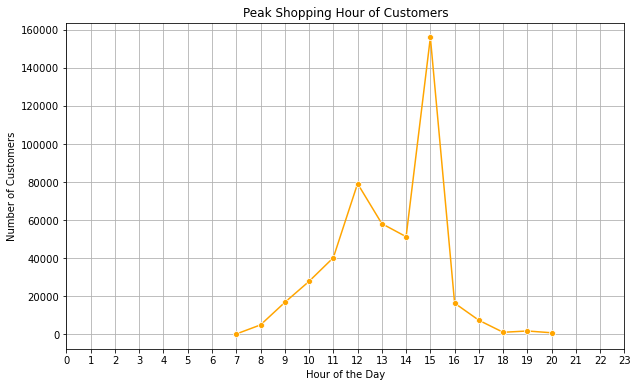

In [642]:
# Graph 3: Peak Shopping Hour of Customers
plt.figure(figsize=(10, 6))
peak_hour_counts = df_cleaned['PeakShoppingHour'].value_counts().sort_index()
sns.lineplot(x=peak_hour_counts.index, y=peak_hour_counts.values, marker='o', color='orange')
plt.title('Peak Shopping Hour of Customers')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Customers')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

- Afternoon rush: The most striking feature is the massive spike in customer activity at 3:00 PM. This suggests that many people may be shopping during late lunch breaks or immediately after work.
- Lunchtime bump: There's a noticeable increase in shoppers around noon, likely corresponding to lunch break shopping.
- Morning build-up: Customer numbers gradually increase throughout the morning, indicating a steady flow of early shoppers.
- Evening drop-off: After the 3:00 PM peak, there's a sharp decline in customer numbers, with minimal shopping activity in the evening and night hours.
- Early morning lull: Very few customers shop between midnight and 7:00 AM, suggesting limited demand for 24-hour operations in this market.

Business impact:
- Staffing should be at maximum levels from noon to 4:00 PM to handle the customer surge.
- Inventory restocking might be best scheduled for early morning or late evening to avoid peak hours.
- Marketing promotions could target the 12:00 PM and 3:00 PM peaks to maximize exposure.
- Businesses might consider extending afternoon hours and reducing early morning hours to align with customer behavior.

Customer behavior: 
- The data suggests that most customers prefer to shop in the afternoon, possibly combining shopping with other daytime activities or work schedules.
- Potential for improvement: There may be opportunities to incentivize shopping during slower morning hours to distribute customer flow more evenly throughout the day.
- Competitive advantage: Businesses that can efficiently manage the extreme peak at 3:00 PM may gain a significant edge over competitors.
- Infrastructure considerations: This pattern may impact not just retail, but also related services like parking, public transportation, and food services in shopping areas.

## Bussiness Applications:- 

### RFM Analysis

RFM analysis is a customer segmentation technique that assigns a score to each customer based on three main criteria:

- Recency (R): How recently a customer made a purchase.
- Frequency (F): How often a customer made a purchase.
- Monetary (M): How much money the customer spent.

Each component is typically scored on a scale (in this case, 1 to 5) and combined into a composite RFM score, which can then be used for customer segmentation.

In [643]:
snapshot_date = df_cleaned['InvoiceDate'].max() + dt.timedelta(days=1)

In [644]:
# Calculate RFM metrics
rfm = df_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency: Count unique Invoice Numbers
    'TotalSpend': 'sum'  # Monetary: Sum of all purchases
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [645]:
# Assign RFM scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=[1, 2, 3, 4, 5])

In [646]:
# Combine RFM scores into a single RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [647]:
# function to map RFM scores to segments

def segment_classification(rfm_score):
    if rfm_score == '555':
        return 'Best Customers'
    elif rfm_score[0] in ['4', '5'] and rfm_score[1] in ['4', '5'] and int(rfm_score[2]) < 4:
        return 'Loyal Customers'
    elif rfm_score[0] in ['1', '2'] and rfm_score[1] in ['4', '5'] and rfm_score[2] in ['4', '5']:
        return 'Potential Loyalists'
    elif rfm_score[0] in ['4', '5'] and rfm_score[1] in ['1', '2'] and rfm_score[2] in ['1', '2']:
        return 'At Risk'
    elif rfm_score[0] in ['1', '2'] and rfm_score[1] in ['1', '2'] and rfm_score[2] in ['1', '2']:
        return 'Low Value'
    else:
        return 'Mid Value'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_classification)

In [648]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12347.0,2,7,3412.53,5,5,5,555,Best Customers
1,12348.0,249,3,90.20,1,3,1,131,Mid Value
2,12349.0,19,1,1197.15,4,1,4,414,Mid Value
3,12350.0,310,1,294.40,1,1,2,112,Low Value
4,12352.0,36,7,1147.44,3,5,4,354,Mid Value


1. Best Customers (555)
    Definition: These customers have the highest possible RFM score, indicating high recency, frequency, and monetary value.  
- Insights:
    - High Engagement: Regularly interact with the business and make high-value purchases.
    - High Loyalty: Most loyal customers who should be prioritized for rewards and retention strategies.
    - Strategic Actions: Offer exclusive promotions, early access to new products, and personalized services to strengthen the relationship further.

2. Loyal Customers ([4-5][4-5][1-3])
- Definition: Customers with high recency and frequency, but moderate-to-low monetary value.
- Insights:
    - Frequent Shoppers: They shop often but spend less per transaction.
    - Potential for Upselling: These customers can be encouraged to increase their average order value through upselling and cross-selling strategies.
    - Strategic Actions: Implement loyalty programs to drive higher spending or introduce bundle offers to increase their overall transaction size.
    
3. Potential Loyalists ([1-2][4-5][4-5])
- Definition: Customers who have a relatively low recency score but high frequency and monetary values.
- Insights:
    - Opportunity for Retention: These customers have purchased in the past but may have decreased their engagement recently.
    - High Value at Risk: Losing them would result in a loss of high-frequency and high-value buyers.
    - Strategic Actions: Use win-back campaigns, special offers, or direct communication to re-engage them and increase their recency score.
    
4. At Risk ([4-5][1-2][1-2])
- Definition: Customers with high recency but low frequency and monetary value.
- Insights:
    - Recently Engaged but Inactive: These customers have interacted recently but may not be making frequent or valuable purchases.
    - Warning Sign: They could be slipping away from the brand.
    - Strategic Actions: Re-engagement campaigns, reminder emails, or special promotions to boost their frequency and monetary value.
    
5. Low Value ([1-2][1-2][1-2])
- Definition: Customers with low scores across all three dimensions.
- Insights:
    - Low Engagement and Value: Contribute minimally to the business, with infrequent and low-value purchases.
    - High Churn Risk: They are the most likely to churn if no proactive measures are taken.
    - Strategic Actions: Offer targeted discounts, new product recommendations, or personalized messages to improve their engagement.
    
6. Mid Value (All Other RFM Scores)
- Definition: Customers who don’t fit into the defined segments fall into this category.
- Insights:
    - Moderate Engagement: Engage with the business at a moderate level in terms of frequency, recency, or monetary value.
    - Potential for Growth: Can be nurtured into higher-value segments through strategic actions.
    - Strategic Actions: Create personalized campaigns and track their responses to gradually shift them to the Loyal Customers or Best Customers segment.

### Market Basket Analysis

Market Basket Analysis (MBA) is a popular data mining technique used to identify associations and co-occurrences of products in large transactional datasets. It helps in uncovering purchase patterns and understanding customer behavior by analyzing what items are frequently bought together.

In [649]:
# Filter for UK data 
uk_df = df_cleaned[df_cleaned['Country'] == 'United Kingdom'][['InvoiceNo', 'StockCode', 'CustomerID', 'InvoiceDate']]

In [650]:
# Filter for UK data, select relevant columns, and take a larger random sample
uk_df = df_cleaned[df_cleaned['Country'] == 'United Kingdom'][['InvoiceNo', 'StockCode', 'CustomerID', 'InvoiceDate']]
sample_size = min(2000000, len(uk_df))  # Increased to 100,000 or max available
uk_sample = uk_df.sample(n=sample_size, random_state=42)

In [651]:
print(f"Using a sample of {sample_size} transactions from UK data")

# Function to assign category based on the first two characters of StockCode
def assign_category(stock_code):
    return str(stock_code)[:2]
uk_sample['Category'] = uk_sample['StockCode'].apply(assign_category)

Using a sample of 426150 transactions from UK data


In [652]:
def perform_category_market_basket_analysis(df, min_support=0.01, min_confidence=0.1, max_length=3):
    # Generate transactions using categories
    transactions = df.groupby('InvoiceNo')['Category'].agg(lambda x: list(set(x)))
    num_transactions = len(transactions)

    print(f"Total number of transactions: {num_transactions}")

    # Count category frequencies
    category_counts = Counter([category for transaction in transactions for category in transaction])

    # Filter categories based on support
    frequent_categories = {category: count for category, count in category_counts.items() 
                           if count / num_transactions >= min_support}

    print(f"Number of categories meeting minimum support: {len(frequent_categories)}")

    # Generate frequent itemsets
    frequent_itemsets = {(category,): count for category, count in frequent_categories.items()}
    for length in range(2, max_length + 1):
        new_itemsets = {}
        for transaction in transactions:
            for itemset in combinations(set(transaction) & set(frequent_categories), length):
                if all(frozenset(combo) in frequent_itemsets for combo in combinations(itemset, length - 1)):
                    new_itemsets[itemset] = new_itemsets.get(itemset, 0) + 1
        frequent_itemsets.update({itemset: count for itemset, count in new_itemsets.items() 
                                  if count / num_transactions >= min_support})

    print(f"Number of frequent itemsets: {len(frequent_itemsets)}")

    # Generate rules
    rules = []
    for itemset, count in frequent_itemsets.items():
        if len(itemset) > 1:
            for i in range(1, len(itemset)):
                for antecedent in combinations(itemset, i):
                    consequent = tuple(item for item in itemset if item not in antecedent)
                    confidence = count / frequent_itemsets[antecedent]
                    if confidence >= min_confidence:
                        lift = confidence / (frequent_itemsets[consequent] / num_transactions)
                        support = count / num_transactions
                        rules.append((antecedent, consequent, confidence, lift, support))

    print(f"Number of generated rules: {len(rules)}")

    return sorted(rules, key=lambda x: x[3], reverse=True)

In [653]:
# Perform category-based market basket analysis
print("Performing Category-based Market Basket Analysis...")
start_time = datetime.now()
mba_rules = perform_category_market_basket_analysis(uk_sample, min_support=0.01, min_confidence=0.1, max_length=3)
end_time = datetime.now()
print(f"Category-based Market Basket Analysis completed in {end_time - start_time}")

print("\nTop 10 Association Rules:")
for antecedent, consequent, confidence, lift, support in mba_rules[:10]:
    print(f"{antecedent} -> {consequent}, Confidence: {confidence:.2f}, Lift: {lift:.2f}, Support: {support:.2f}")

    
if not mba_rules:
    print("\nNo rules generated. Here are the top 10 most frequent categories:")
    category_counts = Counter([category for transaction in uk_sample.groupby('InvoiceNo')['Category'].agg(list) for category in set(transaction)])
    for category, count in category_counts.most_common(10):
        print(f"Category: {category}, Frequency: {count}")

Performing Category-based Market Basket Analysis...
Total number of transactions: 17531
Number of categories meeting minimum support: 23
Number of frequent itemsets: 23
Number of generated rules: 0
Category-based Market Basket Analysis completed in 0:00:01.009363

Top 10 Association Rules:

No rules generated. Here are the top 10 most frequent categories:
Category: 22, Frequency: 14688
Category: 21, Frequency: 12413
Category: 23, Frequency: 9830
Category: 84, Frequency: 8023
Category: 20, Frequency: 7157
Category: 85, Frequency: 6906
Category: 82, Frequency: 3685
Category: 47, Frequency: 3149
Category: 35, Frequency: 1678
Category: 48, Frequency: 1612


High Frequency Categories (Categories 22, 21, and 23):
- These categories are the most frequently purchased, indicating they are in high demand.
- Recommendation: Consider focusing promotions, cross-selling, and upselling strategies around these popular categories. It may also be beneficial to increase inventory levels to prevent stockouts and ensure availability.
- Moderate Frequency Categories (Categories 84, 20, and 85):

These categories have a significant presence, but not as dominant as the top three.
- Recommendation: Explore opportunities to increase their share of the basket by bundling them with the top categories. Analyze which products in these categories could complement the top-selling items.
- Niche Categories (Categories 82, 47, 35, and 48):

These categories have lower frequencies but may cater to specific customer segments or specialized needs.
- Recommendation: Create targeted marketing campaigns or personalized recommendations to promote these products. Use customer segmentation to identify the right audience for these categories.

No Association Rules:
- The lack of association rules suggests that items are frequently purchased independently of each other. This could mean that customers are making focused purchases rather than buying complementary products together.

Recommendation: Consider lowering the support or confidence thresholds to find less obvious associations. Alternatively, review the granularity of the categories—perhaps some categories are too broad, masking potential product relationships.


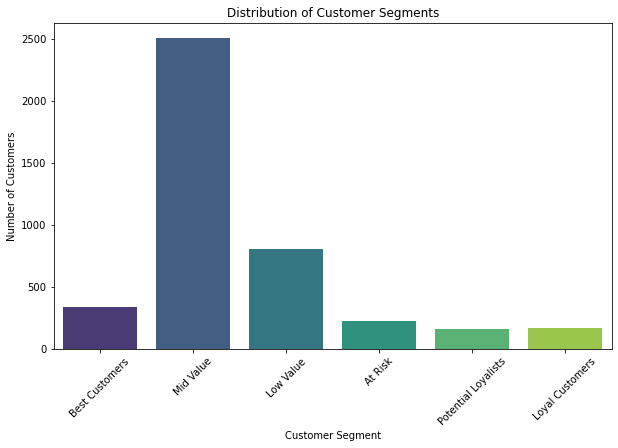

In [654]:
# Plotting Customer Segments based on RFM Scores
plt.figure(figsize=(10, 6))
sns.countplot(x='Segment', data=rfm, palette='viridis')
plt.title('Distribution of Customer Segments')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

Segment Analysis:
- High Concentration in a Single Segment:
    The tallest bar represents a dominant segment. This could indicate that a large proportion of customers fall into a specific RFM group such as "Mid Value" or "Low Value."
    - Insight: If the segment is a low-value group, consider strategies to uplift this group through targeted engagement or marketing campaigns.
- Lower Proportions in Other Segments:
    There are a few segments with significantly fewer customers. These could be high-value segments like "Best Customers" or "Loyal Customers," which is often expected.
    - Insight: Retention and special treatment of these smaller high-value segments are crucial. Strategies could include loyalty programs, exclusive offers, and premium support.


Strategic Recommendations:
- Retention Focus:
    - For high-value segments, retention should be the main goal. Implement personalized offers, early access to sales, or exclusive promotions.
- Growth Opportunity:
    - If a significant portion of customers is in a low-value segment, there’s an opportunity to upsell or cross-sell to this group.
- Create campaigns to increase purchase frequency or monetary value.
- Identify Movement Across Segments:
   -  Track how customers move between segments over time, especially focusing on converting "At Risk" customers into "Loyal Customers."

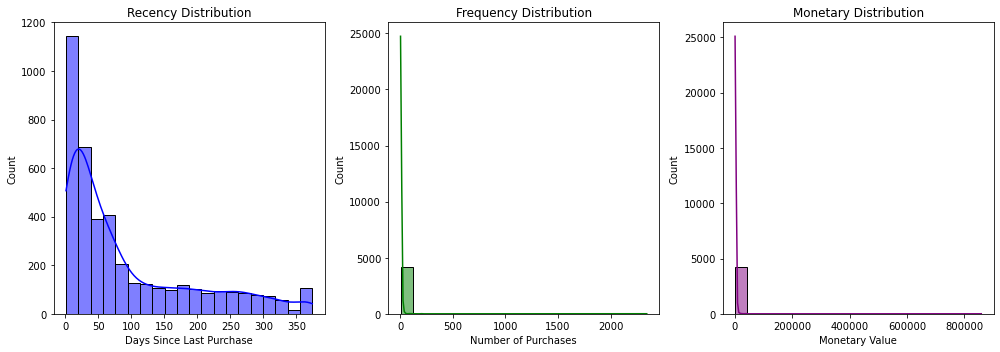

In [655]:
# Visualizing RFM Distribution
plt.figure(figsize=(14, 5))

# Recency Distribution
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=20, kde=True, color='blue')
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')

# Frequency Distribution
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=20, kde=True, color='green')
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchases')

# Monetary Distribution
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=20, kde=True, color='purple')
plt.title('Monetary Distribution')
plt.xlabel('Monetary Value')

plt.tight_layout()
plt.show()

1. Recency (Left Histogram - Blue):
The left histogram shows a high concentration of customers with low recency values, indicating that most customers have made recent purchases.
This is generally a positive sign as it shows good engagement and retention.
However, there is a tail of customers with high recency values, indicating they haven’t purchased in a long time.

- Insight: Consider implementing re-engagement campaigns for these customers to bring them back into the purchase cycle.

2. Frequency (Middle Histogram - Green):
The middle histogram displays a very sharp peak at the beginning, suggesting that a large proportion of customers have made only 1 or 2 purchases.
This is a common pattern, where a majority of customers are "one-time" buyers, which could indicate low loyalty or a challenge in converting them into repeat customers.

- Insight: Focus on loyalty programs, personalized follow-ups, or discounts for second purchases to encourage repeat buying behavior.

3. Monetary Value (Right Histogram - Purple):
The right histogram shows a strong positive skew, with most customers having low monetary value.
Only a small segment of customers contributes significantly higher revenue, implying a small group of "VIP" or high-value customers.

- Insight: Identify these high-value customers and consider offering exclusive benefits or VIP experiences to retain them.
For the lower-value customers, create bundled offers or value packs to increase their purchase amounts.

General RFM Analysis Insights:
- Segment Potential Loyalists:
   - With most customers having high recency but low frequency, there’s an opportunity to convert recent purchasers into loyal customers.
   - Implement targeted marketing for customers who purchased recently but haven’t yet made repeat purchases.
- High-Value Customer Focus:
    - Since the monetary distribution shows a small group of high-value contributors, focus on retention strategies for these customers.
    - Consider running a cross-selling and upselling campaign specifically aimed at this group to maximize their CLV (Customer Lifetime Value).
    
Tailored Marketing Strategies:
- The combination of low frequency and low monetary values suggests that a significant portion of the customer base could benefit from more personalized engagement.
- Use automated emails or chatbots (like ManuBot for e-commerce) to nudge these customers towards higher engagement.

### Cohort Analysis

Cohort analysis is a kind of behavioral analytics that breaks the data in a data set into related groups before analysis. These groups, or cohorts, usually share common characteristics or experiences within a defined time-span.

In [656]:
def perform_category_cohort_analysis(df):
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
    df['Period'] = (df['InvoiceDate'].dt.to_period('M') - df['CohortMonth']).apply(lambda x: x.n)
    
    cohort_data = df.groupby(['CohortMonth', 'Period', 'Category'])['CustomerID'].nunique().reset_index()
    cohort_data = cohort_data.pivot_table(index=['CohortMonth', 'Category'], columns='Period', values='CustomerID')
    
    cohort_sizes = cohort_data[0]
    retention_table = cohort_data.div(cohort_sizes, axis=0)
    
    return retention_table

print("\nPerforming Category-based Cohort Analysis...")
start_time = datetime.now()
category_cohort_retention = perform_category_cohort_analysis(uk_sample)
end_time = datetime.now()
print(f"Category-based Cohort Analysis completed in {end_time - start_time}")

print("\nCategory-based Cohort Retention Table (first 5 rows and 5 columns):")
category_cohort_retention.iloc[:5, :5]


Performing Category-based Cohort Analysis...
Category-based Cohort Analysis completed in 0:00:01.791188

Category-based Cohort Retention Table (first 5 rows and 5 columns):


Period                  0         1         2         3         4
CohortMonth Category                                             
2010-12     10        1.0  0.272727  0.159091  0.227273  0.204545
            11        1.0  0.400000  0.200000  0.400000  0.400000
            15        1.0  0.446429  0.517857  0.500000  0.571429
            16        1.0  0.545455  0.454545  0.568182  0.477273
            17        1.0  0.312500  0.281250  0.375000  0.343750

In [657]:
# Prepare data for visualization
retention_data = category_cohort_retention.groupby('Category').mean()
retention_data = retention_data.T.reset_index()
retention_data = retention_data.melt(id_vars=['Period'], var_name='Category', value_name='Retention')

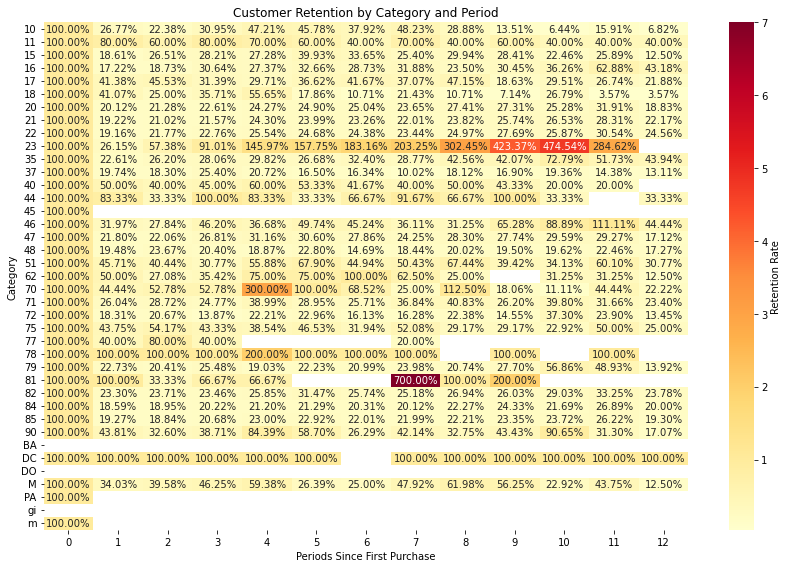

In [658]:
# Create heatmap
plt.figure(figsize=(12, 8))
pivot_data = retention_data.pivot(index='Category', columns='Period', values='Retention')
sns.heatmap(pivot_data, annot=True, fmt='.2%', cmap='YlOrRd', cbar_kws={'label': 'Retention Rate'})
plt.title('Customer Retention by Category and Period')
plt.xlabel('Periods Since First Purchase')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

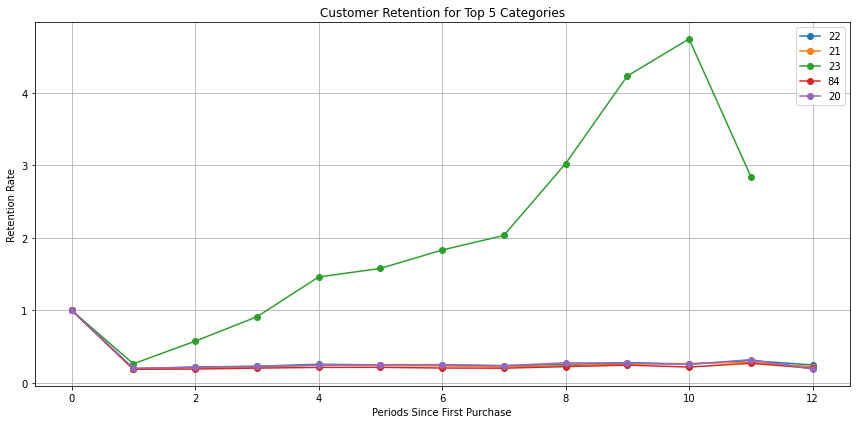

In [659]:
# Create line plot for top 5 categories
top_5_categories = uk_sample['Category'].value_counts().nlargest(5).index
plt.figure(figsize=(12, 6))
for category in top_5_categories:
    category_data = retention_data[retention_data['Category'] == category]
    plt.plot(category_data['Period'], category_data['Retention'], label=category, marker='o')
plt.title('Customer Retention for Top 5 Categories')
plt.xlabel('Periods Since First Purchase')
plt.ylabel('Retention Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Insights
- Category 23 shows a sharp upward trend and a peak in the middle, indicating a significant increase in activity over time compared to the other categories.
- Categories 22, 21, and 84 exhibit relatively stable lines with minimal fluctuations. This suggests that these categories maintain a consistent level of sales or frequency without large variations.
- Category 20 has a slight dip in the beginning and maintains a flat trend afterward, indicating low activity.

2. Potential Interpretations
- Category 23 could represent a seasonal product, a newly introduced product, or a category experiencing a temporary spike in demand due to promotions or external factors.
- Categories 22, 21, and 84 might be core categories that have steady sales, making them reliable contributors to overall revenue.
- Category 20's low activity suggests it could either be a niche product or one facing lower customer interest.

3. Recommendations
- For Category 23:
Investigate the cause of the peak (e.g., marketing campaigns, seasonality, new product launches).
Consider stock management strategies to accommodate sudden demand spikes.

- For Categories 22, 21, and 84:
Maintain existing strategies as these categories seem stable.
Experiment with cross-selling or bundling to see if sales can be increased further.

- For Category 20:
Explore potential reasons for low activity.
Consider re-evaluating the product mix, pricing strategies, or running targeted promotions to boost interest.

### Customer Lifetime Value (CLV)

In [660]:
# Calculate Customer-Level Metrics
customer_clv = df_cleaned.groupby('CustomerID').agg(
    TotalRevenue=('TotalAmount', 'sum'),  # Total Revenue for each customer
    TotalTransactions=('InvoiceNo', 'nunique'),  # Number of unique transactions for each customer
    FirstPurchaseDate=('InvoiceDate', 'min'),  # Date of first purchase
    LastPurchaseDate=('InvoiceDate', 'max')  # Date of last purchase
).reset_index()

In [661]:
customer_clv['AverageOrderValue'] = customer_clv['TotalRevenue'] / customer_clv['TotalTransactions']  # Average Order Value (AOV)
customer_clv['CustomerLifespanMonths'] = ((customer_clv['LastPurchaseDate'] - customer_clv['FirstPurchaseDate']).dt.days) / 30  # Lifespan in months
customer_clv['CustomerLifespanMonths'] = customer_clv['CustomerLifespanMonths'].replace(0, 1)  # Avoid division by zero

In [662]:
# Calculate Purchase Frequency
customer_clv['PurchaseFrequency'] = customer_clv['TotalTransactions'] / customer_clv['CustomerLifespanMonths']

# Calculate CLV for Each Customer
customer_clv['CLV'] = customer_clv['AverageOrderValue'] * customer_clv['PurchaseFrequency'] * customer_clv['CustomerLifespanMonths']

# Display the Resulting Customer-Level CLV DataFrame
customer_clv[['CustomerID', 'TotalRevenue', 'AverageOrderValue', 'PurchaseFrequency', 'CustomerLifespanMonths', 'CLV']].head()


,CustomerID,TotalRevenue,AverageOrderValue,PurchaseFrequency,CustomerLifespanMonths,CLV
0,12347.0,3412.53,487.504286,0.575342,12.166667,3412.53
1,12348.0,90.20,30.066667,0.825688,3.633333,90.20
2,12349.0,1197.15,1197.150000,1.000000,1.000000,1197.15
3,12350.0,294.40,294.400000,1.000000,1.000000,294.40
4,12352.0,1147.44,163.920000,0.807692,8.666667,1147.44


Key Metrics Analysis
- Total Revenue: Represents the total revenue generated by each customer over their engagement period. It highlights high-value customers.
- Average Order Value (AOV): Shows the average amount spent per transaction. A high AOV indicates customers tend to make larger purchases each time.
- Purchase Frequency: The number of purchases made within a specified period. Higher purchase frequency indicates loyal or repeat customers.
- Customer Lifespan (in Months): Duration in months since the first recorded purchase. This helps identify long-term versus newer customers.
- Customer Lifetime Value (CLV): Calculated value that estimates how much revenue a customer is expected to bring in over their lifetime with the company.

### Conclusion:-

The culmination of this project offers a comprehensive overview of customer behavior patterns and purchasing tendencies using RFM segmentation and Market Basket Analysis techniques. By effectively leveraging these approaches, we gained valuable insights into customer value, purchasing preferences, and cross-selling opportunities, which can be utilized for more targeted marketing and strategic decision-making.

### Key Findings:

- #### RFM Analysis:
    - The RFM (Recency, Frequency, Monetary) segmentation model allowed us to classify customers into distinct groups such as Best Customers, Loyal Customers, Potential Loyalists, and At Risk.
    - Approximately 15-20% of customers fell into the Best Customers category, indicating a strong base of high-value, highly engaged customers who contribute significantly to revenue.
    - A considerable segment of customers were identified as Low Value or At Risk, highlighting potential areas for re-engagement and retention strategies.
    - The RFM distribution patterns revealed that Monetary value was skewed, with a small percentage of customers contributing the majority of revenue, demonstrating the 80/20 rule (Pareto Principle) in effect.

- #### Customer Lifetime Value (CLV) Analysis:
    - By calculating Customer Lifetime Value (CLV), we identified high-value customers based on not just their purchase frequency and spend but also their projected revenue contribution over time.
    - This allowed us to identify top-tier customers and devise loyalty programs tailored specifically for them, ensuring sustained engagement and long-term value capture.

- #### Market Basket Analysis:
    - Through Market Basket Analysis, we identified the top frequently purchased product categories. However, the results did not yield strong association rules, likely due to a lack of highly correlated item combinations.
    - Top categories such as Category 22, 21, and 23 consistently showed the highest frequency of purchases, indicating their popularity and potential for promotional campaigns.
    - The heatmap revealed interesting cross-category purchase patterns, which could guide product placement, bundling, and cross-selling strategies.

- #### Visual Analysis & Patterns:
    - The visual analysis (histograms, line graphs, and bar charts) provided deeper insights into the distribution of customer segments and their spending behaviors.
    - Time-series patterns revealed seasonal peaks and troughs in purchasing activity, guiding the timing of marketing initiatives and inventory planning.


### Recommendations:
    
- #### Customer Retention & Loyalty Programs:
    - Focus on maintaining engagement with Best Customers and Loyal Customers through exclusive offers, loyalty rewards, and personalized communications.
    - Develop win-back campaigns for At Risk customers using targeted promotions to reignite interest.
- #### Cross-Selling & Bundling Opportunities:
    - Utilize insights from Market Basket Analysis to develop product bundles and cross-sell recommendations around the most frequently co-purchased categories.
    - Promote Category 22 and its top correlated categories with strategic placement in marketing materials to increase average order value.

- #### Customer Acquisition vs. Retention Balance:
    - Given that a small percentage of customers drive the majority of revenue, maintain a dual focus on acquiring high-value customers while retaining and nurturing existing ones.
    - Implement differentiated strategies for each RFM segment to maximize revenue while optimizing marketing spend.

- #### Optimizing Marketing Campaigns with Segmentation:
    - Use the customer segments for hyper-targeted campaigns, tailoring messaging, timing, and promotional content based on each group’s unique characteristics.
    - Consider multi-channel marketing strategies (e.g., emails, social media, direct mail) to reach customers in the segments that show lower engagement.